<img src='./figures/logo-ecole-polytechnique-ve.jpg' style='position:absolute; top:0; right:0;' width='100px' height='' alt=''/>

<center><b>MAA106: Numerical Analysis Project</b></center>
<center>Authors: Mert Unsal, Philippe Guyard</center>


# A NOTEBOOK ABOUT USEFUL NUMERICAL ANALYSIS AND MOSTLY FOURIER

&nbsp;

**Abstract:** In this project, we will do all the useful mathematics that has the name Fourier in it. This notebook can also be read as a solution to [this document](https://drive.google.com/file/d/1HJ2dywiyDHstflmiuDTi0um787Zayt0Z/view?usp=sharing) but we try to wrote it in a way that it can be uploaded online independently.

In [1]:
# classical library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
%matplotlib inline 

## Starting off with an Example

First of all, we will start with an example to get familiar with the topic. Later, we will build the theory of Fourier Series using inner product spaces.

Fourier series approximation up to degree N of a function $f:\mathbb{R} \to \mathbb{R}$ with period $T = b-a$ is given by:
$$
f(t) = \frac{1}{2} a_0 + \sum_{n=1}^{N} a_n cos(\frac{2 \pi n t}{T}) + \sum_{n=1}^{N} b_n sin(\frac{2 \pi n t}{T})
$$
where
$$
a_n = \frac{2}{T} \int_{a}^{b} f(t) cos(\frac{2 \pi n t}{T}) dt  \quad 1 \leq n \leq N
$$

$$
b_n = \frac{2}{T} \int_{a}^{b} f(t) sin(\frac{2 \pi n t}{T}) dt  \quad 1 \leq n \leq N
$$

Note that different normalizations can be used. 


Let us consider the following function $f: [-\pi, \pi] \to \mathbb{R}$ with period $T = 2 \pi$:

$$ f(t)=   \left\{
\begin{array}{ll}
      1 & |t|\leq \pi/2 \\
      -1 & otherwise \\
\end{array} 
\right.  $$

Since the function is even, the coefficients $b_n = 0$ for $1 \leq n \leq N$. The coefficients $a_n$ can be calculated as follows:

$$
a_n(f) = \frac{1}{\pi} \int_{-\pi}^{\pi} f(t) cos(nt) dt = \frac{2}{\pi} ( \int_{0}^{\pi/2} cos(nt) dt + \int_{\pi/2}^{\pi} cos(nt) dt) = \frac{2}{n\pi} ( sin(n \pi/2) - (-sin(n \pi/2)) = 2 \frac{sin(n \pi/2)}{n \pi/2}
$$

Also note that 
$$
a_0 = \frac{1}{\pi} \int_{-\pi}^{\pi} f(t) dt = 0
$$

Now, let us use these results to numerically evaluate the Fourier Series of $f$.

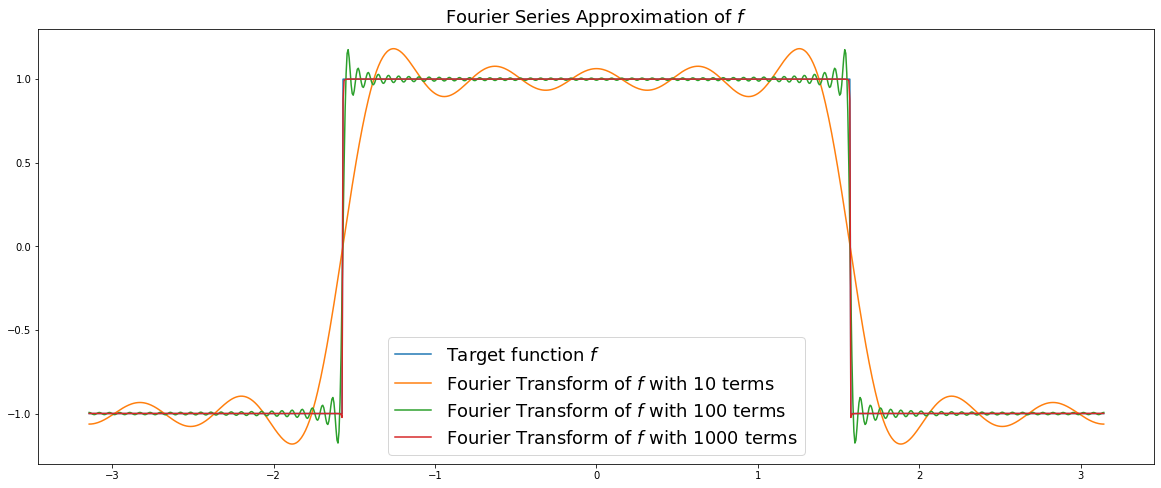

In [2]:
def a(n):
    if n%2 == 0:
        return 0
    y = n*np.pi/2
    return 2 * np.sin(y)/y

def coef(N):
    return np.array([a(i) for i in range(1,N+1)])

def fourier(X, N):
    # X = np.linspace(-np.pi, np.pi, 1000)
    s = np.zeros(len(X))
    n = 1
    for c in coef(N):
        s += c * np.cos(n*X)
        n += 1
    return s

def f(X):
    s = np.zeros(len(X))
    for i in range(len(X)):
        s[i] = 1 if np.abs(X[i]) < np.pi/2 else -1
    return s

X = np.linspace(-np.pi, np.pi, 1000)

plt.figure(figsize=(20, 8))
plt.title('Fourier Series Approximation of $f$', fontsize = 18)
plt.plot(X, f(X), label = 'Target function $f$')
N = 10
plt.plot(X, fourier(X, N), label = f'Fourier Transform of $f$ with {N} terms')
N = 100
plt.plot(X, fourier(X, N), label = f'Fourier Transform of $f$ with {N} terms')
N = 1000
plt.plot(X, fourier(X, N), label = f'Fourier Transform of $f$ with {N} terms')
plt.legend(fontsize = 18)

As we add more terms in the expansion, we get closer to the function we're trying to approximate. However, we also observe that at the discontiniuity points there's always an observable error that doesn't diminish. This effect is currently known as the Gibbs's phenomenon. Let us see how the Fourier coefficients changes with $n$.

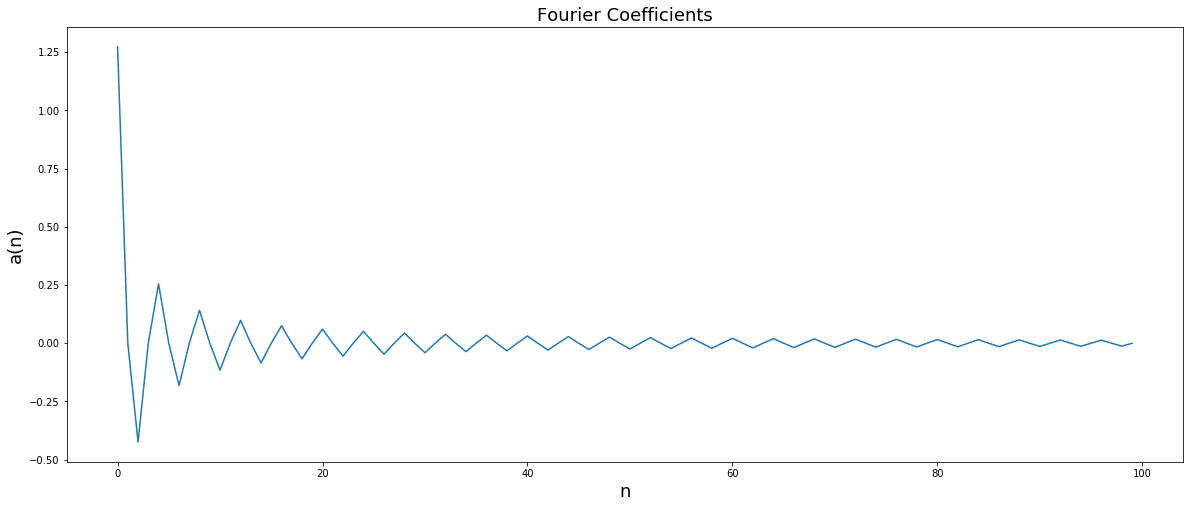

In [3]:
N = 100
X = np.arange(N)


plt.figure(figsize=(20, 8))
plt.title('Fourier Coefficients', fontsize = 18)
plt.xlabel('n', fontsize=18)
plt.ylabel('a(n)', fontsize=18)
plt.plot(X, coef(N))

In this example, we observe that Fourier coefficients tend to $0$ as $n \to \infty$. The first terms contribute much more to the approximation compared to the terms with larger n, or in other words, our function (signal) consists of mostly of low frequency components. As we will prove later, this is a property that holds as long as the functions satisfies some conditions.

## Fourier Series for any periodic function

Now, let us use the general formulas to create a class that allows us to calculate the Fourier series for any function $f$ with period $T$. 

In [4]:
class Fourier:
    """
    A class that allows to calculate and evaluate Fourier coefficients of a periodic function.
    
    Example:
    
    N = 50
    t = np.linspace(0, np.pi, 1000)
    F = Fourier(np.exp,0,np.pi,N)
    a0, coefa, coefb = F.coefficients()
    s = F.evaluate(t, a0, coefa, coefb)
    F.plot(t,s)
    
    """
    
    def __init__(self, f, a, b, N):
        """
        Constructor of the Fourier class.
        
        We assume that the function f is periodic between a and b and has a period of T = b-a.
        
        """
        
        self.f = f
        self.a = a
        self.b = b
        self.N = N
        self.T = b-a
        
    def coefficients(self):
        """
        Parameters
        ----------
            
        Returns
        -------
        (a0,coefa,coefb): tuple
            Coefficients for Fourier Series to be evaluated with the formula above.

        """
        res, err = quad(self.f, self.a, self.b)
        a0 = (2/self.T)*res
        
        coefa = np.zeros(self.N)
        coefb = np.zeros(self.N)
        
        for n in range(self.N):
            res1, err1 = quad(self.fcosn, self.a, self.b, args = (n+1))
            res2, err2 = quad(self.fsinn, self.a, self.b, args = (n+1))
            coefa[n] = (2/self.T)*res1
            coefb[n] = (2/self.T)*res2
            
        return a0,coefa,coefb
        
        
    def evaluate(self, t, a0, coefa, coefb):
        """
        
        Evaluates the Fourier Series for the numpy array t necessarily inside the interval [a,b]
        
        Parameters
        ----------
        t: numpy array
            the points the fourier series will be evaluated
            
        a0, coefa, coefb:
            returns of the Fourier.coefficients() method
            
        Returns
        -------
        s: numpy array
            evaluated fourier series at given points t
            
        """
        l = len(t)
        
        s = np.zeros(l)
        s += a0/2
        
        n = 1
        for an,bn in zip(coefa,coefb):
            s += an * np.cos((2*np.pi*n*t)/(self.T)) + bn * np.sin((2*np.pi*n*t)/(self.T))
            n += 1
            
        return s
    
    def plot(self,t,s):
        """
        Plots the original function and fourier series
        """
        plt.figure(figsize=(20, 8))
        plt.plot(t, self.f(t), label = 'Target function $f$')
        plt.plot(t, s, label = f'Fourier Transform of $f$ with {self.N} terms')
        plt.legend(fontsize = 18)
        
    # helper functions to calculate fourier series
    
    def fcosn(self,t,n):
        return self.f(t)*np.cos((2*np.pi*n*t)/(self.T))
    
    def fsinn(self,t,n):
        return self.f(t)*np.sin((2*np.pi*n*t)/(self.T))
    

## A Few Examples for Illustration

Let us try to approximate several functions with different regularities to see how the Fourier Series behave as we increase the number of terms in the equation. 

The following functions $f$ can be chosen:

- $\mathcal{C}^\infty$: $f(x) = sin(x) + 2 sin(3x) - 3 cos(5x)$ where $x \in [-2\pi, 2\pi]$
- Continious but derivative not continious: $f(x) = |(x \mod \pi)-\pi/2|$ where $x \in [0, 2\pi]$
- Non-continious: $f(x) = e^{-x \mod \pi}$ where $x \in [0, 2\pi]$ 

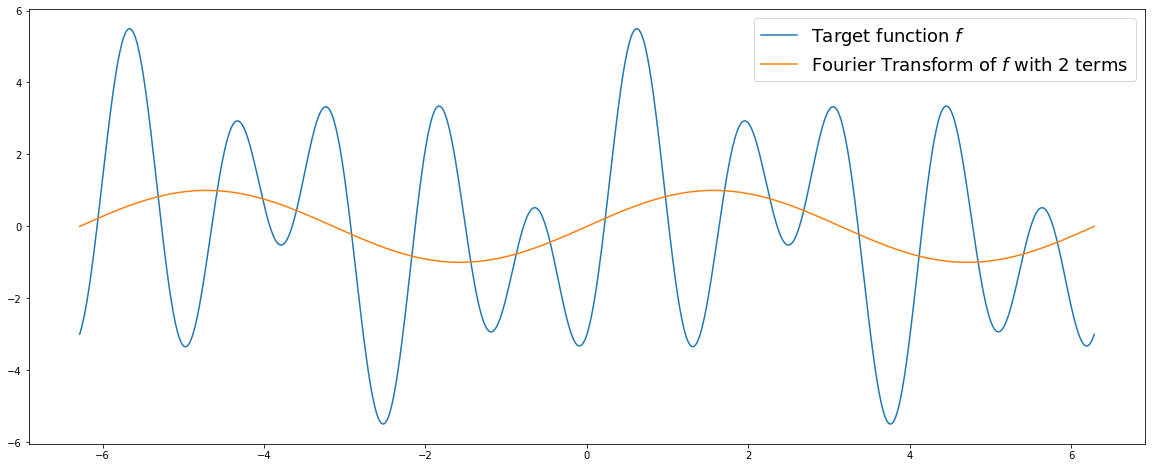

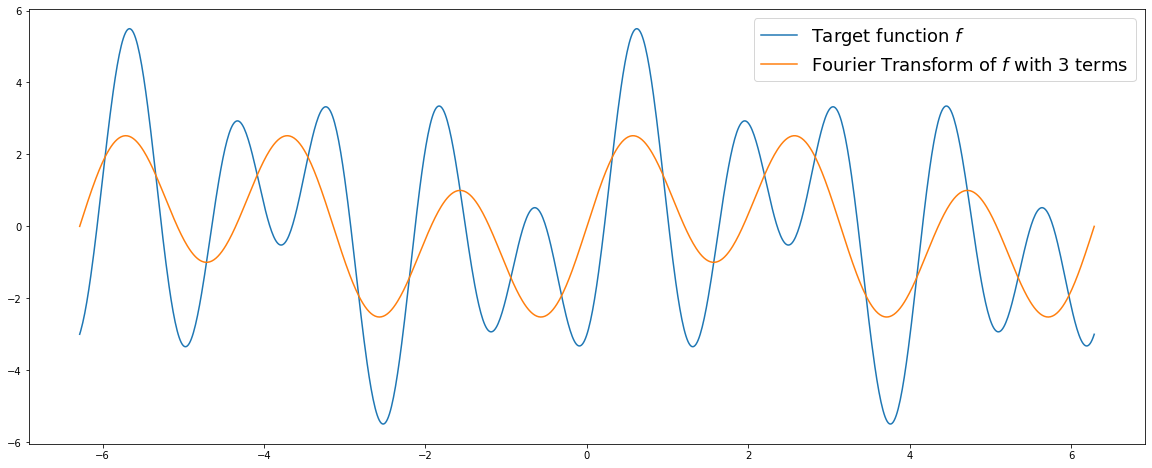

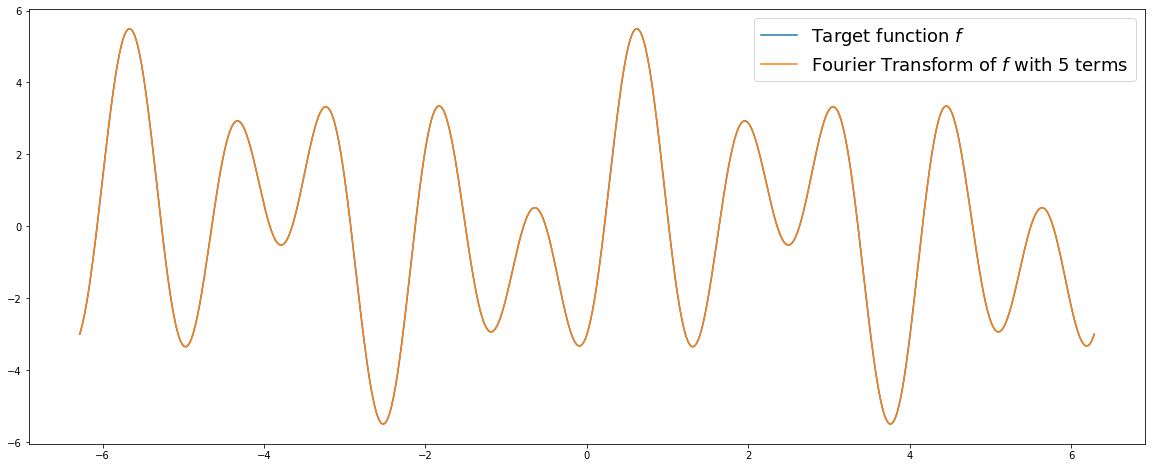

In [5]:
for N in [2,3,5]:
    t = np.linspace(-2*np.pi, 2*np.pi, 1000)
    F = Fourier(lambda X: np.sin(X) + 2* np.sin(3*X) - 3 * np.cos(5*X) ,-np.pi,np.pi,N)
    a0, coefa, coefb = F.coefficients()
    s = F.evaluate(t, a0, coefa, coefb)
    F.plot(t,s)

As expected, the Fourier Series fit the $\mathcal{C}^\infty$ function consisting of sum of sines and cosines perfectly as we add enough terms in the expansion. 

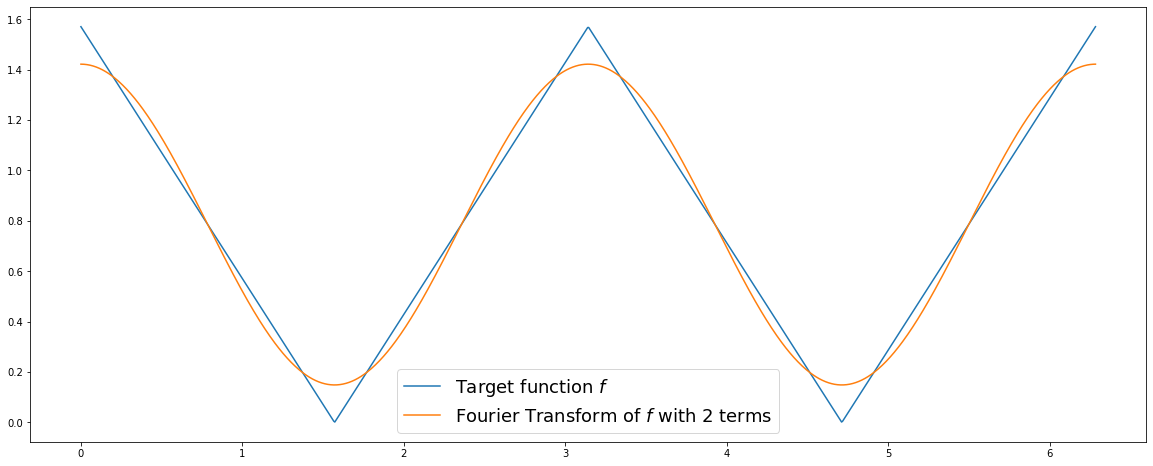

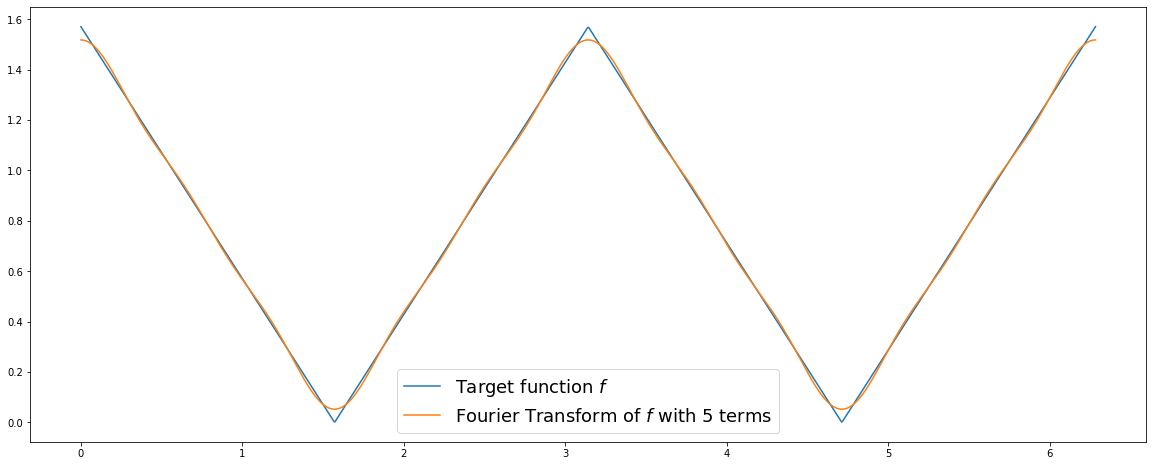

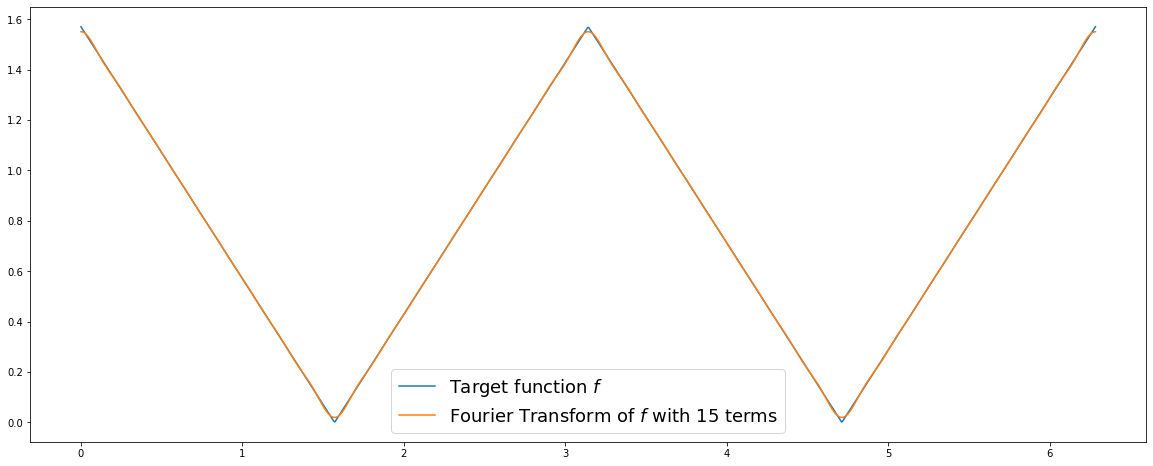

In [6]:
for N in [2,5,15]:
    t = np.linspace(0, 2*np.pi, 1000)
    F = Fourier(lambda X: np.abs((X%np.pi) -np.pi/2),0,np.pi,N)
    a0, coefa, coefb = F.coefficients()
    s = F.evaluate(t, a0, coefa, coefb)
    F.plot(t,s)

We observe that Fourier series seems to fit the function well except that the derivative of the Fourier series will always be continious whereas the function's derivative is discontinious at some points.

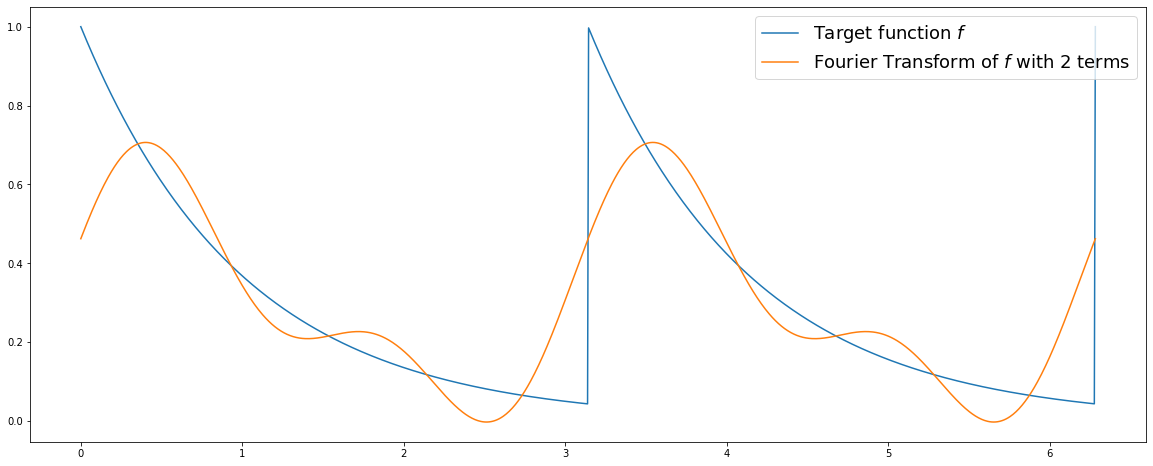

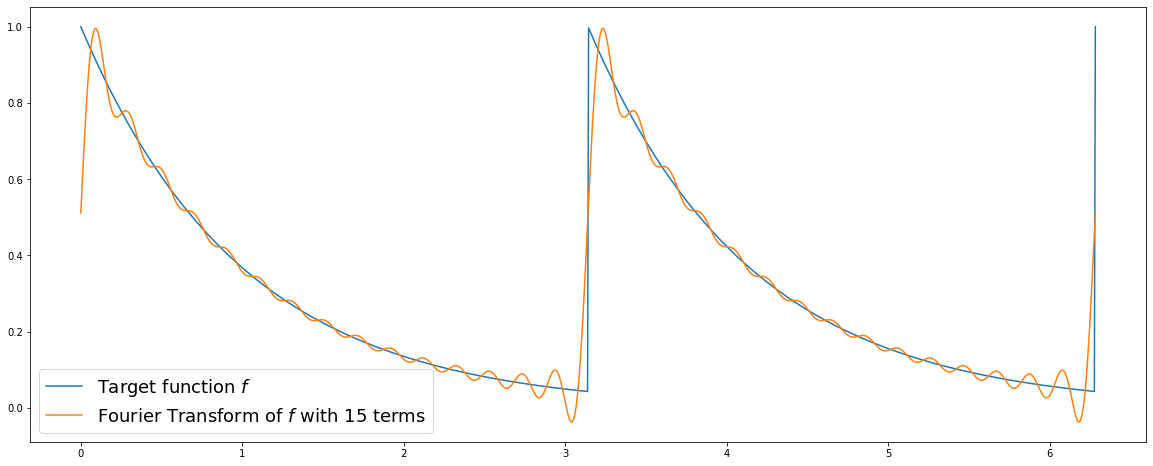

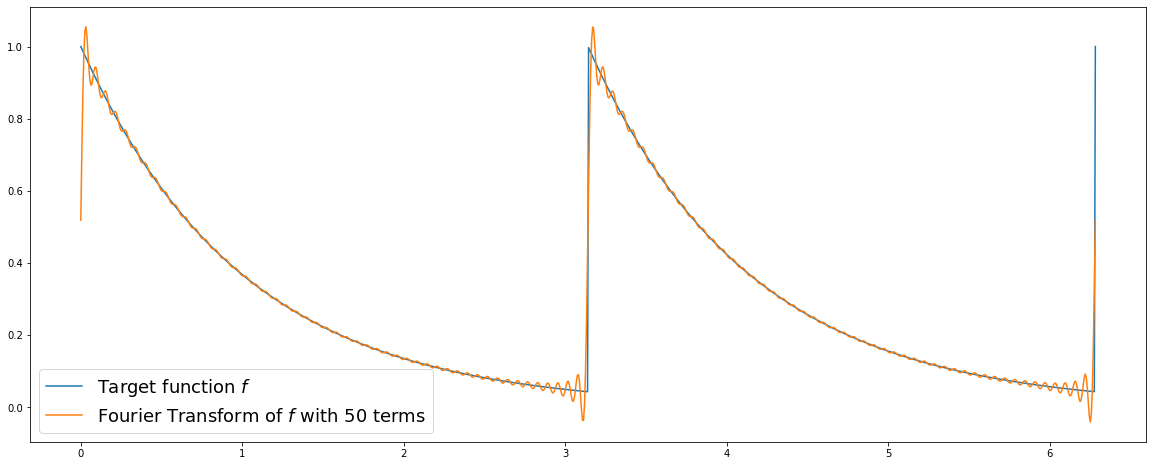

In [7]:
for N in [2,15,50]:
    t = np.linspace(0, 2*np.pi, 1000)
    F = Fourier(lambda X: np.exp(-(X%np.pi)),0,np.pi,N)
    a0, coefa, coefb = F.coefficients()
    s = F.evaluate(t, a0, coefa, coefb)
    F.plot(t,s)

We observe that at the point of discontinuities the Fourier series tends to be at the middle point and there's an overshoot that doesn't diminish as we increase the number of terms. This is known as the Gibbs's Phenomenon and we will prove the middle point property at discontiniuties in the next theory chapter.

## Theory of Fourier Series

### Inner Product Spaces and Infinite Closed Orthonormal Systems

In this chapter, we will make an algebraic construction for the Fourier Series using inner product spaces. This part along with the Discrete and Fast Fourier Transform consists the independent part of the MAA106 project. 

For simplicity, we will consider the linear vector space of complex-valued piecewise continious functions defined on the interval $[-\pi, \pi]$ and we will denote this vector space by $E$. It's easy to show that this constitutes a vector space. For each $f,g \in E$, let us define the following inner product:

$$
    <f,g> = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x)g^{*}(x) dx
$$

where * denotes the complex conjugate. Note that the integral exists since multiplication of two piecewise continious functions give a piecewise continious function. It's easy to prove that this definition indeed satisfies the axioms of an inner product. It's a well-known fact that an inner product on a vector space inherently defines a norm as follows (for $K$-vector spaces):

$$
||f|| = \sqrt{<f,f>}
$$

Now, let us find a closed infinite orthonormal system for the infinite-dimensional space $E$. Here closedness is defined as follows:

**Definition:** Let ${e_1, e_2, ...}$ be an infinite orthonormal system in an inner product space $E$. We will say that this system is closed in $E$ if for all $v \in E$, we have:

$$
\lim_{m \to \infty} || v - \sum_{k=1}^{m} <v,e_k> e_k || = 0
$$

In other words, we need our infinite orthonormal system to be able to *converge in norm* to any vector in $E$.

As expected, we will consider the sine and cosine functions as a infinite orthonormal closed system for $E$.

### Properties of 'Fourier Basis'

**Theorem:** The system

$$
W = \{\frac{1}{\sqrt{2}}, sin(x), cos(x), sin(2x), cos(2x), ...\}
$$

is an infinite orthonormal system in $E$. For the proof, one needs to check the following properties which are easy to prove:

$$
    <1/\sqrt{2}, 1/\sqrt{2}> = \frac{1}{2\pi} \int_{-\pi}^{\pi} dx = 1
$$
$$
    <sin(nx), sin(nx)> = \frac{1}{\pi} \int_{-\pi}^{\pi} sin^2(nx) dx = 1 \quad \forall n \in \mathbf{N}
$$
$$
    <cos(nx), cos(nx)> = \frac{1}{\pi} \int_{-\pi}^{\pi} cos^2(nx) dx = 1 \quad \forall n \in \mathbf{N}
$$
$$
    <1/\sqrt{2}, sin(nx)> = \frac{1}{\sqrt{2}\pi} \int_{-\pi}^{\pi} sin(nx) dx = 0 \quad \forall n \in \mathbf{N}
$$
$$
    <1/\sqrt{2}, cos(nx)> = \frac{1}{\sqrt{2}\pi} \int_{-\pi}^{\pi} cos(nx) dx = 0 \quad \forall n \in \mathbf{N}
$$
$$
    <cos(nx), cos(mx)> = \frac{1}{\pi} \int_{-\pi}^{\pi} cos(nx)cos(mx) dx = 0 \quad \forall n,m \in \mathbf{N} \quad n\neq m
$$
$$
    <sin(nx), sin(mx)> = \frac{1}{\pi} \int_{-\pi}^{\pi} sin(nx)sin(mx) dx = 0 \quad \forall n,m \in \mathbf{N} \quad n\neq m
$$
$$
    <cos(nx), sin(mx)> = \frac{1}{\pi} \int_{-\pi}^{\pi} cos(nx) sin(mx) dx = 0 \quad \forall n,m \in \mathbf{N}
$$

We leave the proof of closedness of the system to later. Given this orthonormal system $W$, we can represent each $f \in E$ in the form

$$
\sum_{k=1}^{\infty} <f,e_k> e_k 
$$

in the subspace $span(W)$. The terms can be calculated as follows:

$$
<f, \frac{1}{\sqrt(2)}> \frac{1}{\sqrt{2}} = \frac{1}{2 \pi} \int_{-\pi}^{\pi} f(t) dt
$$
$$
<f, sin(nx)> sin(nx) = (\frac{1}{\pi} \int_{-\pi}^{\pi} f(t) sin(nt) dt) sin(nx)
$$
$$
<f, cos(nx)> cos(nx) = (\frac{1}{\pi} \int_{-\pi}^{\pi} f(t) cos(nt) dt) cos(nx)
$$

Hence, the Fourier series of $f$ can be written as 

$$
F_m(x) = \frac{a_0}{2} + \sum_{n=1}^{m} [a_n cos(nx) + b_n sin(nx)]
$$
$$
F(x) = \lim_{m \to \infty} F_m(x)
$$

where 

$$
a_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(t) cos(nt) dt
$$

$$
b_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(t) sin(nt) dt
$$

Note that if we change the values of function $f$ at a finite number of points, then the coefficients stay the same. For this reason we can consider two functions which differ at a finite number of points as equivalent. 

The closure property of the Fourier orthonormal system, which will be proven later, ensures that:

$$
\lim_{m \to \infty} \frac{1}{\pi} \int_{-\pi}^{\pi} |f(x) - F_m(x)|^2 dx = 0
$$

However, this doesn't ensure pointwise or uniform convergence for the Fourier series of a function $f$. So, we start by stating the Dirichlet's Theorem:

### Dirichlet's Theorem

**Theorem:** Let $E' \subset E$ be a set of functions such that:

- At each $x \in [-\pi, \pi)$, the following limit exists:

$$
\lim_{h \to 0^+} \frac{f(x+h) - f(x_+)}{h} 
$$

- At each $x \in (-\pi, \pi]$, the following limit exists:

$$
\lim_{h \to 0^+} \frac{f(x_-) - f(x-h)}{h} 
$$

where 

$$
f(x_-) = lim_{h \to 0} f(x-h) \quad f(x_+) = lim_{h \to 0} f(x+h)
$$

denote the left and right limits, respectively. In short, we say that both one-sided derivatives exists on each point if it is possible to take them.

Let $f \in E'$. Then Fourier series of $f$ converges to

$$
    \frac{f(x_-) + f(x_+)}{2} \quad \forall x \in (-\pi, \pi)
$$

and for the endpoints $x = \pm \pi$, it converges to:

$$
    \frac{f(\pi_-) + f((-\pi)+)}{2}
$$

Before we prove the theorem, which is quite long and tedious, let us make the following very crucial observation on this result:

- Observe that if the function is continious, we have $\frac{f(x_-) + f(x_+)}{2} = f(x)$. Hence, we conclude that the Fourier series converge to the same value of the function $f(x)$ for all $x \in (-\pi, \pi)$ if the function is continious. In addition, if we have $f(-\pi) = f(\pi)$, then we can extend the convergence for all $x \in [-\pi, \pi]$.

Now, let us first prove the following proposition which will be useful in the proof of Dirichlet's Theorem:

**Proposition:**

$$
F_m(x) = \frac{a_0}{2} + \sum_{k=1}^{m} [a_n cos(nx) + b_n sin(nx)] = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x+t) \frac{sin((m+1/2)t)}{2 sin(t/2)} dt
$$

>**Proof.** By definition, 
>
>$$
    F_m(x) = \frac{1}{2\pi} \int_{-\pi}^{\pi} f(t) dt + \frac{1}{\pi} \sum_{k=1}^{m} [cos(kx) \int_{-\pi}^{\pi} f(s) cos(ks) ds  + sin(kx) \int_{-\pi}^{\pi} f(s) sin(ks) ds ]
$$
>$$
= \frac{1}{\pi} \int_{-\pi}^{\pi} f(s) \left[\frac{1}{2} + \sum_{k=1}^{m} [cos(ks)cos(kx) + sin(ks)sin(kx)] \right] ds
$$
>$$
= \frac{1}{\pi} \int_{-\pi}^{\pi} f(s) \left[\frac{1}{2} + \sum_{k=1}^{m} cos(k(s-x)) \right] ds
>$$
>Substituting $t = s-x$ and using 
$$\frac{1}{2} + \sum_{k=1}^{m} cos(kt) = \frac{sin((m+1/2)t)}{2 sin(t/2)}$$
>we obtain the final formula:
>$$
F_m(x) = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x+t) \frac{sin((m+1/2)t)}{2 sin(t/2)} dt
$$
>This concludes the proof.

Note that the trigonometric identity above also ensures that:

$$
\int_{0}^{\pi} D_m(t)dt = \int_{0}^{\pi} \frac{sin((m+1/2)t)}{2 sin(t/2)} = \frac{\pi}{2} + \sum_{k=1}^{m} \int_{0}^{\pi} cos(kt) dt = \frac{\pi}{2}
$$

where $D_m(t)$ is called the Dirichlet kernel. Now, let us get back to proving Dirichlet's Theorem, for each $x$:

$$
    \lim_{m \to \infty} F_m(x) = \frac{f(x_-) + f(x_+)}{2}
$$

>**Proof.** We have,
>
>$$
\lim_{m \to \infty} F_m(x) = \frac{1}{\pi} \lim_{m \to \infty} \int_{-\pi}^{\pi} f(x+t) D_m(t) dt = \lim_{m \to \infty} \left[ \frac{1}{\pi} \int_{-\pi}^{0} f(x+t) D_m(t) dt + \frac{1}{\pi}  \int_{0}^{\pi} f(x+t) D_m(t) dt \right]
$$
>
>To prove that the first term is $f(x_-)/2$ and second term is $f(x_+)/2$, we define the function:
>
>$$
    g(t) = \frac{f(x+t) - f(x_+)}{2 sin(t/2)} 
$$
>
>Observe that $g$ is piecewise continious on $[0,\pi]$. The interval $(0,\pi]$ is obvious and the following limit exists since $f >\in E'$
>
>$$
    \lim_{t \to 0^+} g(t) = \left(\lim_{t \to 0^+} \frac{f(x+t) - f(x^+)}{t}\right) \left(\lim_{t \to 0^+} \frac{t}{2 sin(t/2)}\right) = \lim_{t \to 0^+} \frac{f(x+t) - f(x^+)}{t}
$$
>
>Then, using this property one can prove by expanding the trigonomentric term and using Riemann-Lebesgue Lemma that
>
>$$
    \lim_{m \to \infty} \frac{1}{\pi} \int_{0}^{\pi} g(t) sin((m+1/2)t) dt = 0
$$
>
>Using the definition of $g$:
>
>$$
    \lim_{m \to \infty} \left[ \frac{1}{\pi} \int_{0}^{\pi} \frac{f(x+t)}{2 sin(t/2)} sin((m+1/2)t) dt - \frac{1}{\pi} \int_{0}^{\pi} \frac{f(x_+)}{2 sin(t/2)} sin((m+1/2)t) dt \right]
$$
>Hence, we obtain:
>
>$$
\lim_{m \to \infty} \frac{1}{\pi} \int_{0}^{\pi} \frac{f(x+t)}{2 sin(t/2)} sin((m+1/2)t) dt = \lim_{m \to \infty} \frac{1}{\pi} \int_{0}^{\pi} \frac{f(x_+)}{2 sin(t/2)} sin((m+1/2)t) dt = \frac{f(x_+)}{\pi} \int_{0}^{\pi} D_m(t) dt = \frac{f(x_+)}{2}
$$
>
>Similarly, one can prove that:
>$$
\lim_{m \to \infty} \frac{1}{\pi} \int_{-\pi}^{0} \frac{f(x+t)}{2 sin(t/2)} sin((m+1/2)t) dt = \frac{f(x_-)}{2}
$$
>
>This concludes the proof.

This result proves the pointwise-convergence under some circumstances. However, we are also interested in uniform convergence of Fourier series. Let us prove the following theorem for the Fourier coefficients. 

### Uniform Convergence of Fourier Series
**Theorem:** Let $f \in E, \mathcal{C}^k[a,b]$ be a $2 \pi$ periodic function where $k>0$. Then

$$
|a_n| < \frac{C}{n^k} \quad |b_n| < \frac{C}{n^k}
$$

where $C$ is a constant.

>**Proof.** Let's assume that $f \in \mathcal{C}^1[a,b]$. Then, 
>
>$$
b_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(t) sin(nt) dt = \frac{1}{\pi n} \left([-f(t)cos(nt) ]_{-\pi}^\pi + \int_{-\pi}^\pi f'(t) cos(nt) dt \right) = \frac{1}{\pi n} \int_{-\pi}^\pi f'(t) cos(nt) dt
$$
>
>Since $f'$ is continious on $[a,b]$ which is a compact set, it is bounded. This implies that the term after $\frac{1}{\pi n}$ is bounded by a constant. Hence, we have
>
>$$
b_n < \frac{C}{n}
$$
>
>for some constant C. A similar result can be proved for $a_n$. The same process can be conducted if $f$ is smoother and each iteration will bring a term $\frac{1}{n}$. This concludes the proof.

Now, let us use this result to prove the convergence of the Fourier Series.

**Theorem:** Let $f \in \mathcal{C}[-\pi,\pi]$ be a $2\pi$ periodic function such that $f(-\pi) = f(\pi)$ and $f' \in E$. Then, the Fourier Series converge uniformly to the function.

>**Proof.** When we approximate the function $f$ with its series $S_N$ which includes the terms up to $a_N$ and $b_N$, we have the following error:
>$$
    sup |F_N(t) - f(t)| \leq sup |\sum_{n=N+1}^{\infty} a_n cos(nt) + b_n sin(nt) | \leq \sum_{n=N+1}^{\infty} |a_n| + |b_n| \rightarrow 0 \quad as \quad N \to \infty
$$
>
>Since the coefficients tend to zero as n tends to $\infty$ thanks to continuity assumption, for any $\epsilon > 0$, we can find a large $N$ such that the sum on the RHS is smaller than $\epsilon$. We conclude that the Fourier Series uniformly converge to $f$ under these conditions:
>
>$$
    \lim_{N \to \infty} F_N(t) = f(t) \quad \forall t \in [a, b]
$$
>

### Closedness of the Fourier Basis
Finally, it can be proved that the basis $W$ is closed for the given set of functions but I realized it will take way too many calculations and mathematics. So it is beyond the scope of this elementary study. But we can still prove that $W$ is a closed infinite orthonormal system for continious functions. This is obvious since Fourier series converge uniformly for continious functions:

$$
     ||f(x) - F_m(x)||^2 = \frac{1}{\pi} \int_{-\pi}^{\pi} |f(x) - F_m(x)|^2 dx \leq \frac{1}{\pi} \epsilon^2 2 \pi = 2 \epsilon^2
$$

since we can find $m$ large enough such that $|f(x) - F_m(x)| < \epsilon$ for any $\epsilon > 0$.

This concludes the theory of the Fourier Series. Now, we continue to exploring Fourier Transform, Discrete Fourier Transform, and a better implementation of it known as Fast Fourier Transform.

## Fourier Transform, DFT, and FFT

In this chapter, we will define the Fourier Transform, discuss its connections with the Fourier Series, how to use Discrete Fourier Transform to approximate it and a better algorithm to do so, namely the Fast Fourier Transform, developed by Cooley-Tukey.

**Fourier Transform:**

Let $f: \mathbb{R} \to \mathbb{C}$ be a function. Then, we define its Fourier Transform $G: \mathbb{R} \to \mathbb{C}$ as follows:

$$
    G(f) = \int_{- \infty}^{\infty} f(t) e^{-i 2 \pi f t}  dt
$$

It is important to note that giving the definition is not sufficient since there is an integral: one must show that under which conditions this integral exists. However, this is beyond the scope of this notebook. 

First of all, we should note that one of the main motivations behind the Fourier Transform is the Fourier Series. We approximated complicated yet periodic functions using Fourier Series and Fourier Transform is an extension in which the period of the represented function is allowed to approach infinity. Hence, the Fourier Transform can be thought as switching to the frequency spectrum of a given signal/function.

It's a hard task to analytically calculate a Fourier Transform of all functions, hence as always, we start to look for numerical methods. To do so, we introduce the Discrete Fourier Transform.

**Discrete Fourier Transform (DFT):**

The discrete Fourier transform converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency. The DFT and the inverse DFT for a finite sequence of equally-spaced samples ${x_1,...,x_n}$ of a function is given as follows:

$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{- \frac{i 2\pi k n}{N}} \quad 0 \leq k \leq N-1
$$

$$
x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{\frac{i 2\pi k n}{N}} \quad 0 \leq n \leq N-1
$$ 

Since these transformations are quite useful in a lot of applications in science and engineering python has libraries for fast computation. Let us code a very naive DFT function and compare its speed with the numpy version `numpy.fft`. Our naive calculation will be done based on the observation that the transform can be written as a Vandermonde Matrix:

$$
X = M \cdot x \quad where \quad M=\left(\begin{array}{ccccc} 1 & 1 & 1 & \ldots & 1 \\ 1 & \omega & \omega^2 & \ldots & \omega^{N-1} \\ \vdots & & & &\vdots \\ 1 & \omega^{N-1} & \omega^{2(N-1)} & \ldots & \omega^{(N-1)(N-1)} \end{array}\right)
$$

Note that this algorithm to calculate the DFT has $\mathcal{O}[N^2]$ complexity. We carefully code the algorithm using `numpy` functions to utilize the speed of `numpy` based on its C implementation even though we can create them using normal loops.

In [8]:
def DFT(x):
    x = np.asarray(x, dtype=float) # do the type casting
    N = len(x) # take the size
    n = np.arange(N) # create two arrays to create the matrix M 
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

# let us first check if our code is correct
x = np.random.random(1024)
np.allclose(DFT(x), np.fft.fft(x))

True

In [9]:
%timeit DFT(x)
%timeit np.fft.fft(x)

370 ms ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16 µs ± 571 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
(339 * 10**-3)/(16.2 * 10**(-6))

20925.92592592593

We observe that the numpy algorithm works approximately 20000 faster even though they output the same results! Can we improve our algorithm? It turns out the answer is yes (obviously, since the numpy code didn't fall out of the sky) thanks to the Fast Fourier Transform.

**Fast Fourier Transform:**

The Fast Fourier Transform improves the algorithm above by making the following observation for some $\alpha \in \mathbb{N}$:


$$
\begin{align*}
X_{k + \alpha N} &=  \sum_{n=0}^{N-1} x_n \cdot e^{- \frac{i 2\pi (k+ \alpha N) n}{N}}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i 2\pi \alpha n} \cdot e^{- \frac{i 2\pi (k+N) n}{N}}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- \frac{i 2\pi k n}{N}}\\
          &= X_k          
\end{align*}
$$

This symmetry can be exploited to calculate the DFT faster since we can eliminate redoing the same calculations. Cooley-Tukey showed that we can develop a divide-and-conquer algorithm using the following relation:

$$
\begin{align}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)} \\
    &= X_{even}[k] + e^{-i~2\pi~k~/~N} X_{odd}[k]
\end{align}
$$

Observe that here the first term is the DFT of the even terms and the second term is the DFT of odd terms. This obviously doesn't decrease the complexity, however, the trick comes in by making use of the symmetries in each terms. By using the previous observation, we find that

$$
\begin{align}
X_{k+N/2} &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~(k+N/2)~m~/~(N/2)} + e^{-i~2\pi~(k+N/2)~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~(k+N/2)~m~/~(N/2)} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~(k+N/2)~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)} \\
    &= X_{even}[k] + e^{-i~2\pi~k~/~N} e^{-i~\pi} X_{odd}[k] \\
    &= X_{even}[k] - e^{-i~2\pi~k~/~N} X_{odd}[k]
\end{align}
$$

This means that we only need to perform half the operations for each sub-problem.

In [11]:
def FFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N <= 16: 
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        f = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + f[:N // 2] * X_odd, X_even + f[N // 2:] * X_odd])

Hence, all we had to do is to calculate and concatenate even and odd terms using the relation above. In each recursive call operations are of complexity $\Theta(n)$. This gives us the recursive complexity relation:

$$
T(n) = 2 T(n/2) + \Theta(n)
$$

and by Master's Theorem, we conclude that the complexity is $T(n) = \Theta(n \cdot log(n))$. Observe that the algorithm works properly only if the inital size of the array is a power of 2 since we will keep dividing the problem into pieces of half the size. Let us check if our algorithm works properly and do the speed comparisions:

In [12]:
x = np.random.random(1024)
np.allclose(FFT(x), np.fft.fft(x))

True

In [13]:
%timeit DFT(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

332 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.5 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.9 µs ± 3.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Compared to the previous naive algorithm, we observe an improvement of more than a order of magnitude! Still, we are very far from the `numpy` implementation. This is due to the fact that recursion is very slow and we do not make all the optimizations to memorize every computation. The aim of this notebook is to give an understanding of the FFT algorithm and not to make all the optimizations, so we end our journey of exploring the FFT here.

# Trigonometric interpolation

### Answer to theoretical question:
We can get an expression for $\hat{f}_n$ by computing the $n$-th row of $Bf(X)$:
$$ \hat{f}_n = \frac{1}{N} \sum_{k=0}^N f(X_k) \cos(nX_k)$$


Now look at the formula for $a_n(f)$ for even, $2\pi$-periodic functions:
$$ a_n(f) = \frac{1}{\pi}\int_0^\pi f(x) \cos(nx) dx $$
Replacing the integral with the corresponding Riemman sum:
$$
\begin{align*}
a_n(f) &= \frac{1}{\pi} \lim_{n\to\infty} \sum_{k=0}^n f\left(\frac{k\pi}{n}\right)\cos(k\pi) \times \frac{\pi}{n} \\
&= \lim_{n\to\infty} \frac{1}{n} \sum_{k=0}^n f\left(\frac{k\pi}{n}\right)\cos(k\pi) \\
& \approx \frac{1}{\tilde{n}} \sum_{k=0}^{\tilde{n}} f\left(\frac{k\pi}{\tilde{n}}\right)\cos(k\pi) & \text{For } \tilde{n}  \text{ sufficiently large}
 \end{align*}
$$
Let $\tilde{X}_k = \frac{k\pi}{\tilde{n}}$. Then we can rewrite $a_n(f)$ as
$$ a_n(f) = \frac{1}{\tilde{n}} \sum_{k=0}^{\tilde{n}} f\left(\tilde{X}_k\right)\cos(\tilde{n}\tilde{X}_k) $$
We conclude that $\hat{f}_n$ and $a_n(f)$ has the same form when we approximate the integral using the same nodes.
&nbsp;

In [14]:
def eval_poly(f_hat, mesh):
    '''
    Evaluation of an interpolation Polynomial with coefficients f_hat on a mesh
    -----------------------
    Inputs:
    f_hat : the coefficients of the interpolation polynomial
    mesh: the mesh to evaluate the polynomial on

    Output: 
    an array containing the values P_n(f)(x) for each x in mesh
    '''
    N = len(f_hat) + 1
    res = np.ones(len(mesh)) * f_hat[0]
    for i in range(1, len(f_hat)):
        res += 2 * f_hat[i] * np.cos(i * mesh)
    
    return res

In [15]:
from scipy.fftpack import dct, idct

class Approximator:
    def __init__(self, func, N):
        self.function = func
        self.N = N

        self.X = (2 * np.arange(0, N) + 1) * np.pi / (2 * N)
        self.Y = np.array(list(map(self.function, self.X))) #f(X)

    def approximate_direct(self):
        '''
        Computation of the coefficients of the trigonometric interpolation polynomial of self.function
        using direct matrix multiplication
        -----------------------
        Inputs:
        self: we use self.Y as the values to interpolate and self.X as the interpolation points

        Output: 
        f_hat : the coefficients of the interpolation polynomial
        '''
        #NOTE: This formula is only a guess for the actual matrix A
        #the computation of A might not be very efficient
        
        #A_{i, j} = 2 * cos(i * X_j)
        guessed_A = 2 * np.cos([i * self.X for i in np.arange(0, self.N)])
        #first column is always one
        guessed_A[0] = np.ones(self.N)
        #transpose
        guessed_A = guessed_A.T
                
        #A * f_hat = f
        return np.linalg.solve(guessed_A, self.Y)
        
    def approximate_inverse(self):
        '''
        Computation of the coefficients of the trigonometric interpolation polynomial of self.function
        using inverse matrix multiplication
        -----------------------
        Inputs:
        self: we use self.Y as the values to interpolate and self.X as the interpolation points

        Output: 
        f_hat : the coefficients of the interpolation polynomial
        '''
        #B_{i, j} = cos(i * X_j) / N
        B = np.cos([i * self.X for i in np.arange(0, self.N)]) / self.N
                     
        return np.dot(B, self.Y) #Since f_hat = B * f

    def approximate_fft(self):
        '''
        Computation of the coefficients of the trigonometric interpolation polynomial of self.function
        using Direct Cosine Transform
        -----------------------
        Inputs:
        self: we use self.Y as the values to interpolate and self.X as the interpolation points

        Output: 
        f_hat : the coefficients of the interpolation polynomial
        '''
        return dct(self.Y) / (2 * self.N)  
    
    def plot(self, f_hat, title=None):
        '''
        Plot self.function and Pn(f) evaluated on [-1, 1]
        -----------------------
        Inputs:
        self: we use self.function to plot the original function
        f_hat: the coefficient of the vector f_hat that we use to compute Pn(f)

        Output: 
        A plot of self.function and Pn(f) on [-1, 1]
        '''
        #sufficiently fine discretisation of [-1, 1]
        mesh = np.linspace(-np.pi, np.pi, 1001)
        y = np.array(list(map(self.function, mesh)))
        y_hat = eval_poly(f_hat, mesh)
        

        plt.figure(figsize=(20, 8))
        
        plt.subplot(121)
        plt.plot(mesh, y, label='Actual function values')
        plt.plot(mesh, y_hat, label='Interpolated polynomial')
        #because our function is even...
        actual_X = np.concatenate((-self.X, self.X))
        actual_Y = np.concatenate((self.Y, self.Y))
        plt.scatter(actual_X, actual_Y, label='Interpolation nodes', color='green')
        
        plt.xlim(-np.pi, np.pi)
        
        if title is not None:
            plt.title(title)
        plt.legend()
        plt.plot()
        
        
        plt.subplot(122)
        plt.plot(mesh, abs(y - y_hat), label = '$e_n(f) = |f-P_n(f)|$')
        plt.plot(actual_X, 1e-16*np.ones(len(actual_X)), marker='o', linestyle='', label = 'Interpolation nodes')
        plt.legend(fontsize = 18)
        plt.xlabel('x', fontsize = 18)
        plt.tick_params(labelsize=18)
        plt.yscale('log')
        plt.title('Local interpolation error e_n(f) in log-scale, n= %i' %len(f_hat), fontsize = 18)
    
        plt.show()
        
        print('Global error:', np.max(np.abs(y - y_hat)))

In [16]:
n = 10
#We use a restriction of Runge's function as a test
f = lambda x: 1 / (1 + 25 * x * x)
a = Approximator(f, n)

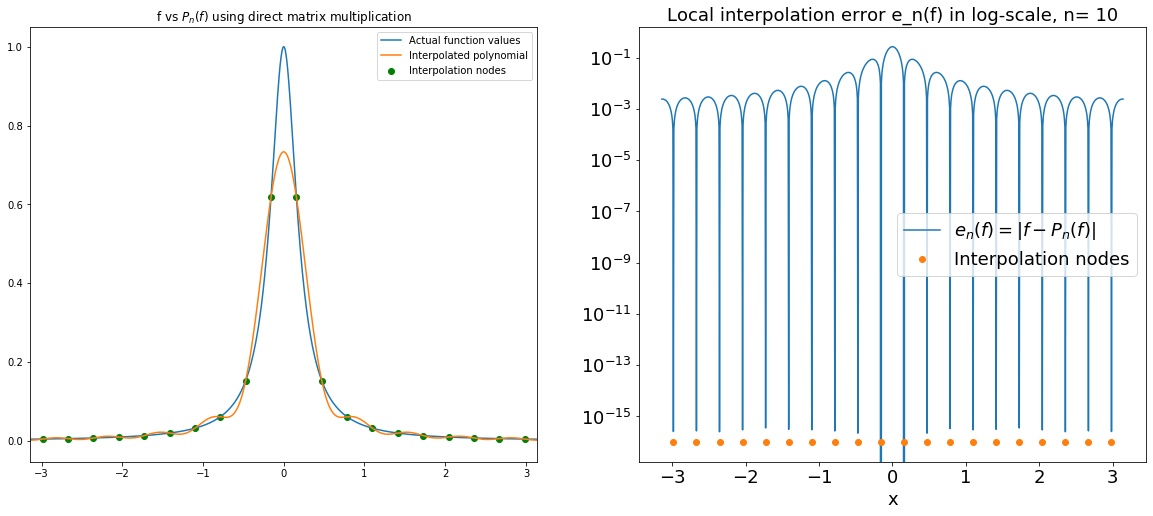

Global error: 0.2666861196905529


In [17]:
f_hat = a.approximate_direct()
a.plot(f_hat, 'f vs $P_n(f)$ using direct matrix multiplication')

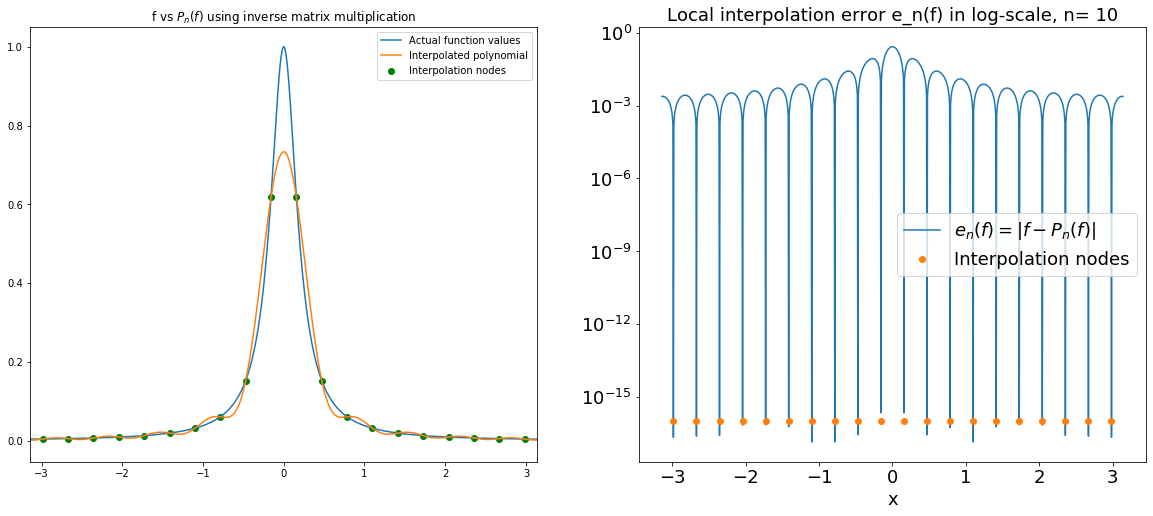

Global error: 0.266686119690553


In [18]:
f_hat = a.approximate_inverse()
a.plot(f_hat, 'f vs $P_n(f)$ using inverse matrix multiplication')

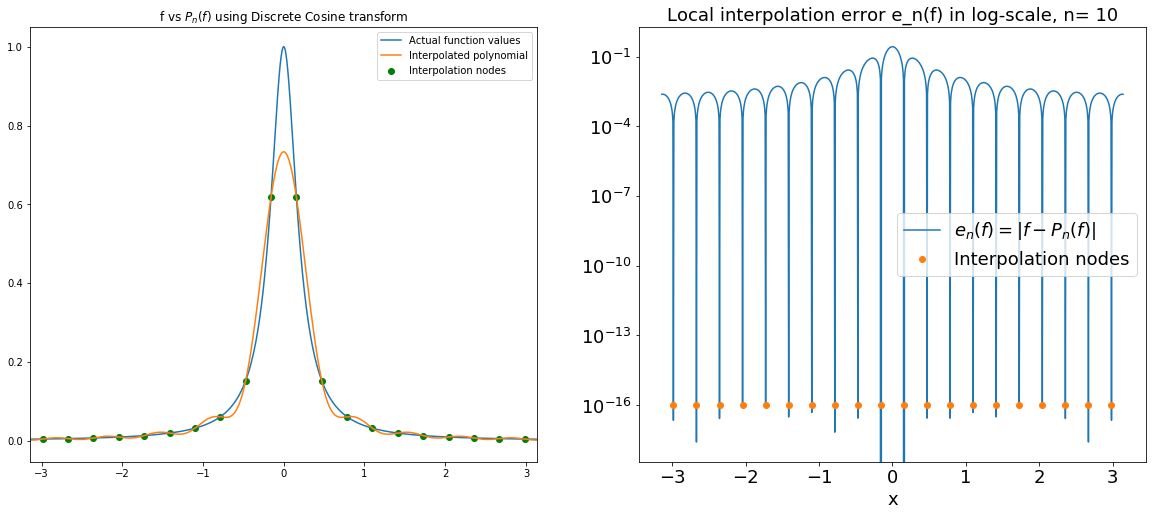

Global error: 0.266686119690553


In [19]:
f_hat = a.approximate_fft()
a.plot(f_hat, 'f vs $P_n(f)$ using Discrete Cosine transform')

As expected, all methods yield the same interpolation polynomial.

### Making sure the error converges

In [20]:
def ErrorGlobal(n_max, f, X):
    tab_n = np.arange(1, n_max + 1)
    tab_Enf = np.zeros(n_max)
    y = np.array(list(map(f, X)))
    for n in tab_n:
        a = Approximator(f, n)
        f_hat = a.approximate_fft()
        y_hat = eval_poly(f_hat, X)
        
        tab_Enf[n - 1] = np.max(np.abs(y - y_hat))
    
    return tab_n, tab_Enf

**The case of piecewise continuity**

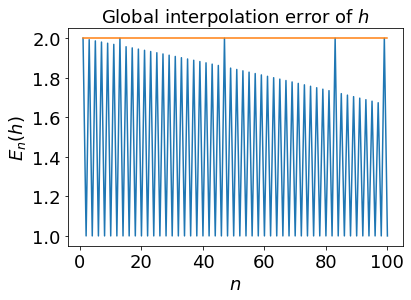

In [21]:
h = lambda x: 1 if -np.pi / 2 <= x <= np.pi / 2 else -1
n_max = 100
X = np.linspace(-np.pi, np.pi, 1001)
tab_n, tab_Enf = ErrorGlobal(n_max, h, X)

plt.plot(tab_n, tab_Enf)
plt.plot(tab_n, [2] * len(tab_n))
#plt.legend(fontsize = 18)
#plt.yscale('log')
plt.title('Global interpolation error of $h$', fontsize = 18)
plt.xlabel('$n$',fontsize = 18)
plt.ylabel('$E_{n}(h)$',fontsize = 18)
plt.tick_params(labelsize=18)

plt.show()

One can notice that the $E_n(h)$ is bounded from below by $1$. Indeed, if we look at the discontinuity (straight line from $(-\frac{\pi}{2}, -1)$ to $(-\frac{\pi}{2}, 1)$), we can conclude that the best value for $Pnh$ to have at $x = -\frac{\pi}{2}$ is $y = 0$, but this still yields an error of 1.

The error also reaches $2$ infinitely many times

**Back to "more normal" functions**

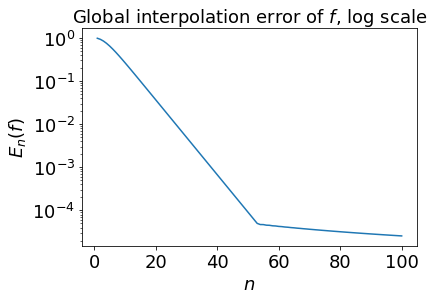

In [22]:
n_max = 100
X = np.linspace(-np.pi, np.pi, 1001)
tab_n, tab_Enf = ErrorGlobal(n_max, f, X)

plt.plot(tab_n, tab_Enf)
#plt.legend(fontsize = 18)
plt.yscale('log')
plt.title('Global interpolation error of $f$, log scale', fontsize = 18)
plt.xlabel('$n$',fontsize = 18)
plt.ylabel('$E_{n}(f)$',fontsize = 18)
plt.tick_params(labelsize=18)

plt.show()

Now let us introduce a new function $g: [-\pi, \pi] \mapsto 1 - \frac{2|x|}{\pi}$

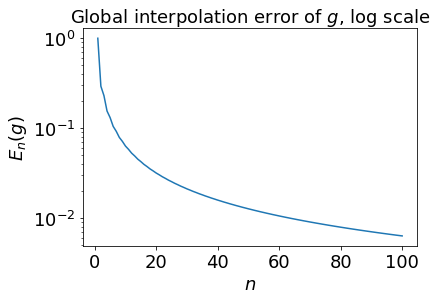

In [23]:
g = lambda x: 1 - 2 * np.abs(x) / np.pi
n_max = 100
X = np.linspace(-np.pi, np.pi, 1001)
tab_n, tab_Enf = ErrorGlobal(n_max, g, X)

plt.plot(tab_n, tab_Enf)
#plt.legend(fontsize = 18)
plt.yscale('log')
plt.title('Global interpolation error of $g$, log scale', fontsize = 18)
plt.xlabel('$n$',fontsize = 18)
plt.ylabel('$E_{n}(g)$',fontsize = 18)
plt.tick_params(labelsize=18)

plt.show()

Both functions seem to show global convergence. It looks like the speed of convergence is relatively big at first, but then becomes smaller

### A new method to check error convergence 

We will design a new algorithm to check global error convergence. Instead of going through all $n$ and looking at the global error at each of those $n$, we will use *binary search* to find the smallest *reasonable* $n$ ($1 \leq n \leq n_{max}$) such that $E_n(f) < \epsilon$, where $\epsilon$ is an "error milestone" we want to reach. 

Since we want to do this for multiple milestones, we will also introduce a "cache" dictionnary, to avoid recalculating error for the same $n$ multiple times.

In [24]:
def does_reach(f, eps, n_max=10000, err_cache=None):
    #create a cache to speed up the process
    cache = dict(err_cache) if err_cache is not None else {}
    
    l, r = 1, n_max
    reach = False
    #We assume that 10 * n_max points is a sufficiently fine discretization
    X = np.linspace(-np.pi, np.pi, 10 * n_max)
    y = np.array([f(x) for x in X])
    while l < r:
        n = (l + r) // 2
        err = np.inf #This will be set in one of the 'if' branches
        if n in cache:
            err = cache[n]
        else:
            a = Approximator(f, n)
            f_hat = a.approximate_fft()
            y_hat = eval_poly(f_hat, X)

            err = np.max(np.abs(y - y_hat))
            cache[n] = err
            
        #error was reached, now searching for minimal n
        if err < eps:
            r = n - 1
            reach = True
        else:
            l = n + 1
    
    #At this n (n = ), error is roughly eps (or n_max)
    return reach, l, cache

**Note:** We suggest not to run the following two cells agains since it takes ages to run :)

In [25]:
epsilons = 1 / 10 ** np.arange(1, 7)
cache = None
print('Error milestones for the function g:')
for eps in epsilons:
    print('=' * 32)
    print('Trying to reach milestone:', eps)
    can_reach, n, cache = does_reach(g, eps, err_cache=cache)
    if can_reach:
        print('Error is approximately', eps, 'at n =', n)
    else:
        print('This milestone is never reached (given n_max=10000)')
        #Hence we cannot reach any epsilon < eps
        break

Error milestones for the function g:
Trying to reach milestone: 0.1
Error is approximately 0.1 at n = 7
Trying to reach milestone: 0.01
Error is approximately 0.01 at n = 64
Trying to reach milestone: 0.001
Error is approximately 0.001 at n = 637
Trying to reach milestone: 0.0001
Error is approximately 0.0001 at n = 6366
Trying to reach milestone: 1e-05
This milestone is never reached (given n_max=10000)


From here one can estimate that $E_n(g) \leq 10^{-k} \iff n > 7 \times 10^{k - 1}$ and see that there is indeed global convergence.

In [26]:
epsilons = 1 / 10 ** np.arange(1, 8)
cache = None
print('Error milestones for the function f:')
for eps in epsilons:
    print('=' * 32)
    print('Trying to reach milestone:', eps)
    can_reach, n, cache = does_reach(f, eps, n_max=10000, err_cache=cache)
    if can_reach:
        print('Error is approximately', eps, 'at n =', n)
    else:
        print('This milestone is never reached (given n_max=10000)')
        #Hence we cannot reach any epsilon < eps
        break

Error milestones for the function f:
Trying to reach milestone: 0.1
Error is approximately 0.1 at n = 15
Trying to reach milestone: 0.01
Error is approximately 0.01 at n = 27
Trying to reach milestone: 0.001
Error is approximately 0.001 at n = 38
Trying to reach milestone: 0.0001
Error is approximately 0.0001 at n = 49
Trying to reach milestone: 1e-05
Error is approximately 1e-05 at n = 256
Trying to reach milestone: 1e-06
Error is approximately 1e-06 at n = 2559
Trying to reach milestone: 1e-07
This milestone is never reached (given n_max=10000)


From here one can estimate that there is indeed global convergence.

## Conclusions

- We conclude that our method to check global convergence provides a fast ($O(\log n)$ vs $O(n)$ asymptotic) way to check wheter $E_n(f)$ goes $0$ as $n$ goes to infinity. 

- However, it should be noted that $E_n(f)$ is assumed to be *strictly decreasing*, otherwise the binary search algorithm does not work. In practice, the algorithm usually works even if there are occasional disruptions since the probability to landing on those are negligible. 

### Measuring time for different approaches and values of n

In [27]:
f = lambda x: 1 if -np.pi / 2 <= x <= np.pi / 2 else -1
for n in range(5, 31, 5):
    a = Approximator(f, n)
    print('==========================')
    print('N =', n)
    print('Approximation using self-coded direct matrix:')
    %timeit a.approximate_direct()
    print()
    print('Approximation using self-coded inverse matrix:')
    %timeit a.approximate_inverse()
    print()
    print('Approximation using scipy.fftpack.dct:')
    %timeit a.approximate_fft()
    print()

N = 5
Approximation using self-coded direct matrix:
144 µs ± 3.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Approximation using self-coded inverse matrix:
68 µs ± 708 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Approximation using scipy.fftpack.dct:
124 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

N = 10
Approximation using self-coded direct matrix:
208 µs ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Approximation using self-coded inverse matrix:
119 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Approximation using scipy.fftpack.dct:
56.4 µs ± 4.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

N = 15
Approximation using self-coded direct matrix:
245 µs ± 8.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Approximation using self-coded inverse matrix:
173 µs ± 6.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Approximation using scipy.fftpack.

Make a test with lots of nodes to see how much faster is `scipy.fftpack.dct` compared to our own implementations

In [28]:
n = 100 
a = Approximator(f, n)
print('N =', n)
print('Approximation using self-coded direct matrix:')
%timeit a.approximate_direct()
print()
print('Approximation using self-coded inverse matrix:')
%timeit a.approximate_inverse()
print()
print('Approximation using scipy.fftpack.dct:')
%timeit a.approximate_fft()

N = 100
Approximation using self-coded direct matrix:
1.49 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Approximation using self-coded inverse matrix:
1.12 ms ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Approximation using scipy.fftpack.dct:
56.4 µs ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Conclusions

It looks like `scipy.fftpack.dct` is most efficient (in terms of time) at computing the interpolation polynomial

While the difference is barely noticeable for a small number of nodes (for example, `dct` is only $3$ times faster for `n=5`), our implementations are way worse assymptotically. For `n=100`, `dct` is roughly $50$ times faster than our implementation of Discrete Cosine Transform (the one where we solve a linear system)

# Section 3.2 - A new way to interpolate polynomials

In this section, we will try to interpolate the following nasty function:

$$
F(x) = tanh(20 sin(15 x)) + 0.02 e^{3x} sin(300 x)
$$

## Theoretical preface

Assume that we need to interpolate a function $F: [-1, 1] \mapsto \mathbb{R}$ (and we are given $N$ data points).

> Define $f: t \mapsto F(\cos t)$. Then $f$ is $2\pi$ peridoc and even. 
>
> One can compute $\hat{f}$ using methods from **section 2**. Than use the formula $f(x) \approx \hat{f}_0 + 2\sum_{n=1}^{N-1} \hat{f}_n \cos(nx)$
>
> But $f \circ \arccos: x \in [-1; 1] \mapsto F(\cos(\arccos x))$. So $F = f \circ \arccos$
>
> Hence we have $F(x) \approx \hat{f}_0 + 2\sum_{n=1}^{N-1} \hat{f}_n \cos(n\arccos(x))$, which is a polynomial.

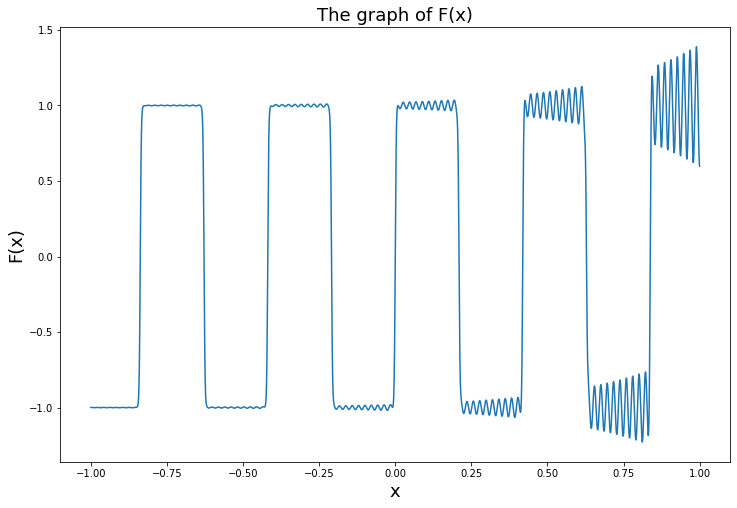

In [29]:
#Take a look at the given function
F = lambda x: np.tanh(20 * np.sin(15 * x)) + 0.02 * np.exp(3 * x) * np.sin(300 * x)
linspace = np.linspace(-1, 1, 10001)

plt.figure(figsize=(12, 8))
plt.plot(linspace, F(linspace))
plt.xlabel('x', fontsize=18)
plt.ylabel('F(x)', fontsize=18)
plt.title('The graph of F(x)', fontsize=18)

plt.show()

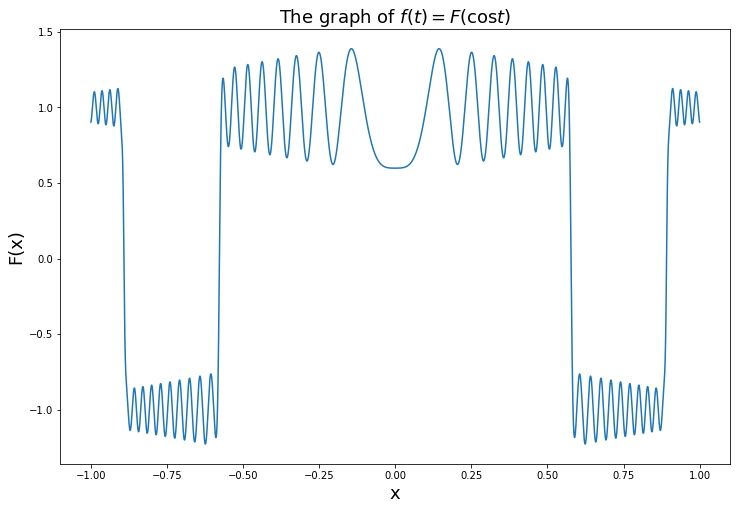

In [30]:
f = lambda t: F(np.cos(t))

plt.figure(figsize=(12, 8))
plt.plot(linspace, f(linspace))
plt.xlabel('x', fontsize=18)
plt.ylabel('F(x)', fontsize=18)
plt.title('The graph of $f(t) = F(\cos t)$', fontsize=18)

plt.show()

In [31]:
#The function is nasty, so we choose a big n
n = 100
a = Approximator(f, n)

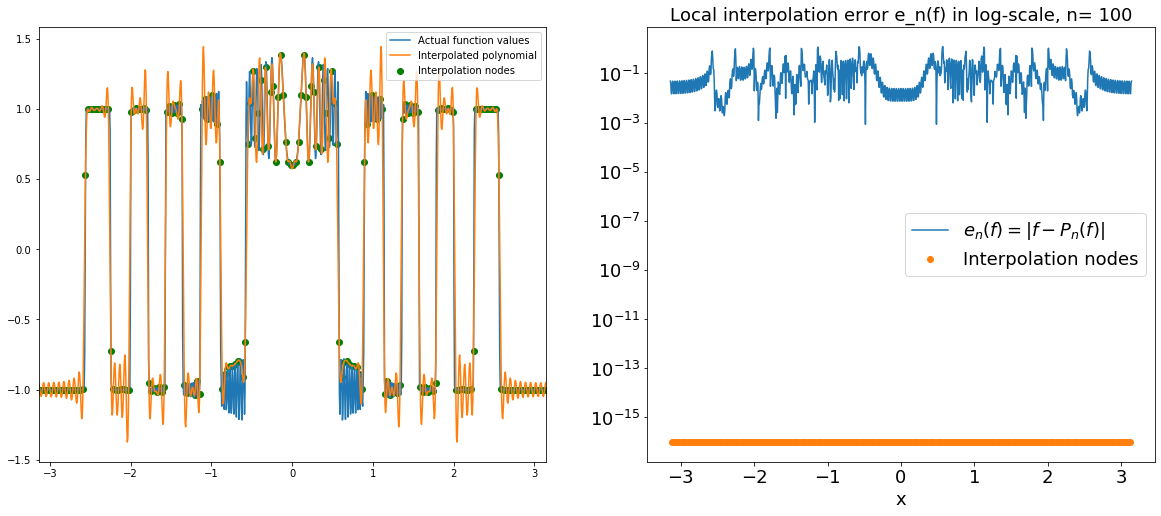

Global error: 1.2331614322248754


In [32]:
f_hat = a.approximate_fft()

a.plot(f_hat)

Local error is relatively big (around $10^{-2}$) even with a big number of sampled nodes ($n=100$). This is not very suprising given the "nastyness" of the function. Still, it seems like our graph converges to the function

In [33]:
def get_poly_new(f_hat):
    '''
    Conversion from vector to polynomial
    -----------------------
    Inputs:
    f_hat : the coefficients of the interpolation polynomial

    Output: 
    The function P_n(f) using the coefficients f_hat
    '''
    N = len(f_hat) + 1
    cos_arr = lambda x: np.cos(np.arccos(x) * np.arange(1, N - 1))
    return lambda x: f_hat[0] + 2 * np.dot(f_hat[1:], cos_arr(x))
    
def eval_poly_new(f_hat, mesh):
    '''
    Evaluation of an interpolation Polynomial with coefficients f_hat on a mesh
    -----------------------
    Inputs:
    f_hat : the coefficients of the interpolation polynomial
    mesh: the mesh to evaluate the polynomial on

    Output: 
    an array containing the values P_n(f)(x) for each x in mesh
    '''
    Pnf = get_poly_new(f_hat)
    return np.array(list(map(Pnf, mesh)))

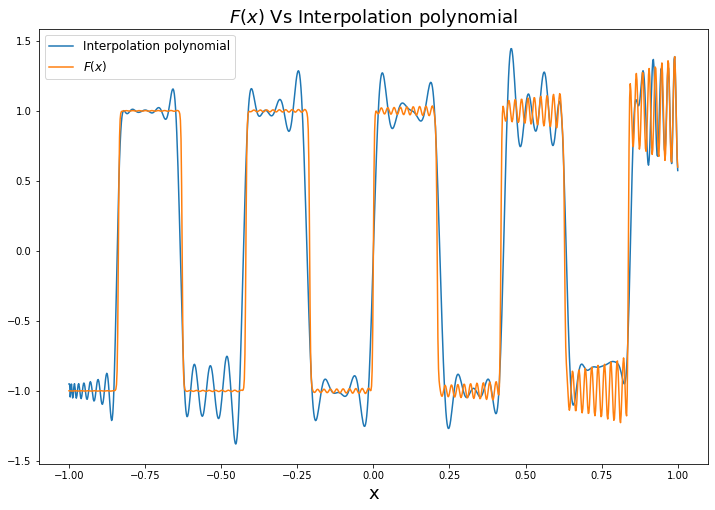

In [34]:
linspace = np.linspace(-1, 1, 10 * n + 1)
PnfX = eval_poly_new(f_hat, linspace)

plt.figure(figsize=(12, 8))
plt.plot(linspace, PnfX, label='Interpolation polynomial')
plt.plot(linspace, F(linspace), label='$F(x)$')
plt.xlabel('x', fontsize=18)
plt.legend(fontsize=12)
plt.title('$F(x)$ Vs Interpolation polynomial', fontsize=18)
plt.show()

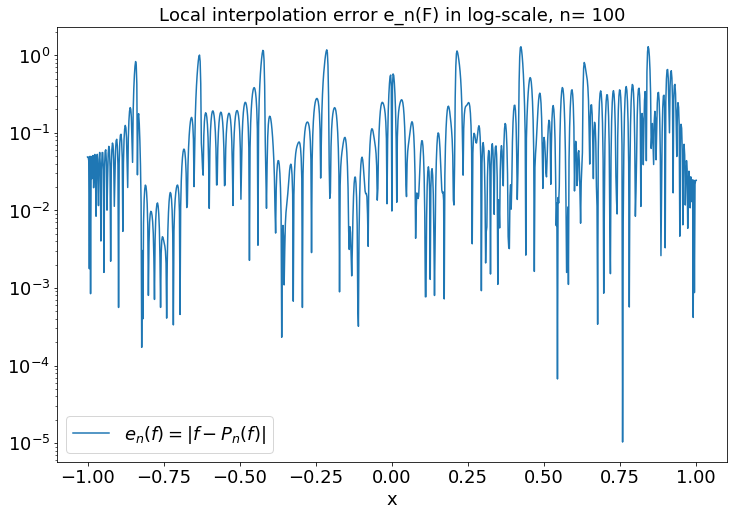

In [35]:
diff = np.abs(PnfX - F(linspace))
#x = a.X

plt.figure(figsize=(12, 8))
plt.plot(linspace, diff, label = '$e_n(f) = |f-P_n(f)|$')
#plt.plot(x, 1e-16*np.ones(x.size), marker='o', linestyle='', label = 'Interpolation nodes')
plt.legend(fontsize = 18)
plt.xlabel('x', fontsize = 18)
plt.tick_params(labelsize=18)
plt.yscale('log')
plt.title('Local interpolation error e_n(F) in log-scale, n= %i' %n, fontsize = 18)
plt.show()

In [36]:
def ErrorGLobal(n_max, f, F, X):
    tab_n = np.arange(1, n_max + 1)
    tab_Enf = np.zeros(n_max)
    y = np.array(list(map(F, X))) #F(X)
    for n in tab_n:
        a = Approximator(f, n)
        f_hat = a.approximate_fft()
        PnfX = eval_poly_new(f_hat, X)
        tab_Enf[n - 1] = np.max(np.abs(y - PnfX)) # computation of E_n(f)
        
    return tab_n, tab_Enf

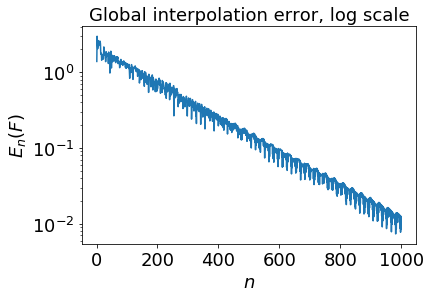

In [37]:
n_max = 1000
X = np.linspace(-1, 1, 10001)
tab_n, tab_Enf = ErrorGLobal(n_max, f, F, X)

plt.plot(tab_n, tab_Enf)
#plt.legend(fontsize = 18)
plt.yscale('log')
plt.title('Global interpolation error, log scale', fontsize = 18)
plt.xlabel('$n$',fontsize = 18)
plt.ylabel('$E_{n}(F)$',fontsize = 18)
plt.tick_params(labelsize=18)

plt.show()

Here we chose $n$ very big to make the convergence clear (one can try $n = 100$ and see that conversion is not trivial), because this function converges very slowly

# Section 3.3 - Applications to Differential Equations

In this section, we consider the following differential equation, which is well known as the Poisson differential equation:

$$
    \begin{cases}
      - u''(x) = f(x) \quad \quad x \in (0, \pi) \\
      u'(0) = u'(\pi) = 0
    \end{cases} 
$$

Here, it makes sense to look for solutions in the form:

$$
    u_m(x) = \frac{a_0}{2} + \sum_{n=1}^{m} a_n cos(nx) \\
    u(x) = \lim_{m \to \infty} u_m(x)
$$

Since we have,

$$
    u_m'(x) = - \sum_{n=1}^{m} a_n n sin(nx)
$$

which satisfies the given boundary conditions for $u$:

$$
    u_m'(0) = u_m'(\pi) = 0
$$

In addition, we have the following for the second derivative:

$$
    u_m''(x) = - \sum_{n=1}^{m} a_n n^2 cos(nx)
$$

When we put this into our differential equation, we obtain:

$$
    \sum_{n=1}^{\infty} a_n n^2 cos(nx) = f(x)
$$

This means that if $f$ satisfies the conditions of Fourier Series and if we can write $f$ as such an infinite sum with $b'_n = 0$ and $a'_0 = 0$, we can find the coefficients $a_n$ which in turn will give us solutions to this differential equation:

$$
    f(x) = \sum_{n=1}^{\infty} a'_n cos(nx) = \sum_{n=1}^{\infty} a_n n^2 cos(nx) \implies a_n = \frac{a'_n}{n^2}
$$

Also note that the given expansion satisfies the boundary conditions $f'(0) = f'(\pi) = 0$. However, the solution is not unique since the differential equation will be satisfied for any value of $a_0$. Similarly, if we have a more complicated version of the given differential equation such as:

$$
    \begin{cases}
      - u''(x) + c u(x) = f(x) \quad \quad x \in (0, \pi) \\
      u'(0) = u'(\pi) = 0
    \end{cases} 
$$

Then, we can stil apply this methodology to obtain the following conditions for the coefficients:

$$
    a'_n = (n^2 + c) a_n \implies a_n = \frac{a'_n}{n^2 + c}
$$

However, it is not possible to add the non-linear terms since then there will be multiplication of cosine functions and we end up with an equation that cannot be solved trivially. 

Before going to examples, let us provide a numerical tools calculate first and second derivative numerically so that we can check the correctness of our solutions. Let $\phi$ be a twice-differentiable function. It can be proven by Taylor Expansion that derivative of a function can be approximated as follows:

$$
\phi'(x) = \frac{\phi(x+h/2) - \phi(x-h/2)}{h}  \quad \text{for $h$ small enough}
$$

Similarly, the second derivative can be approximated as follows:

$$
\phi''(x) = \frac{\phi'(x+h/2) - \phi'(x-h/2)}{h} = \frac{\frac{\phi(x+h) - \phi(x)}{h} - \frac{\phi(x) - \phi(x-h)}{h}}{h} = \frac{\phi(x+h) - 2 \phi(x) + \phi(x-h)}{h^2}
$$

Hence, we can use this expression to see if our solutions satisfy the differential equation.

Since we have our framework, let us do an example solution for the following function which satisfies the previous conditions:

$$
    f(x) = \sum_{n=1}^{10} n^2 cos(nx) 
$$

From our framework, the solution is the following for some constant $c$:

$$
    u(x) = c + \sum_{n=1}^{10} cos(nx)
$$

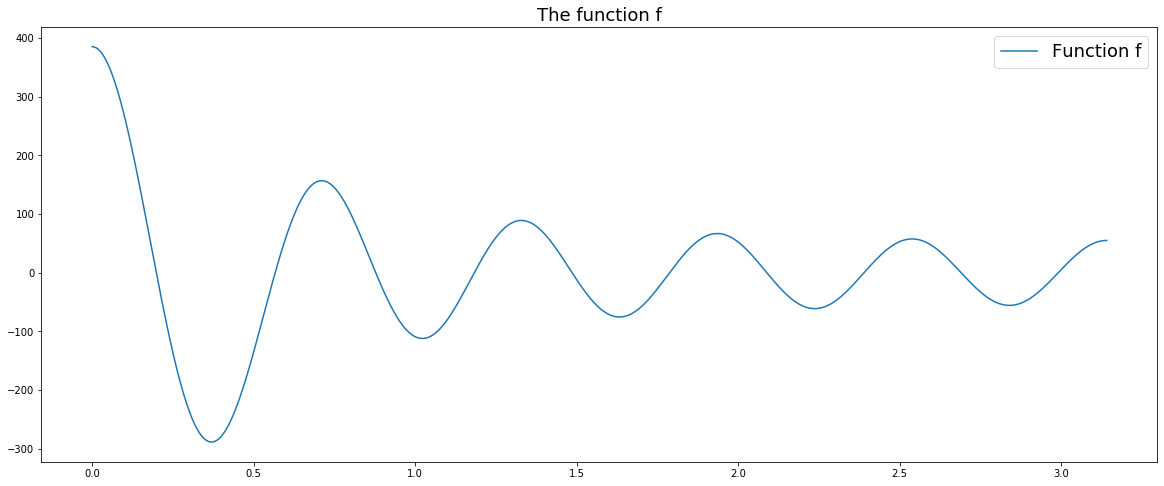

In [38]:
def f(x):
    s = np.zeros(len(x))
    for i in range(1,11):
        s += i**2 * np.cos(i*x)
    return s

# take c = 0
def u(x):
    s = np.zeros(len(x))
    for i in range(1,11):
        s += np.cos(i*x)
    return s

X = np.linspace(0, np.pi, 1000)
plt.figure(figsize=(20, 8))
plt.title('The function f', fontsize = 18)
plt.plot(X, f(X), label = 'Function f')
plt.legend(fontsize = 18)

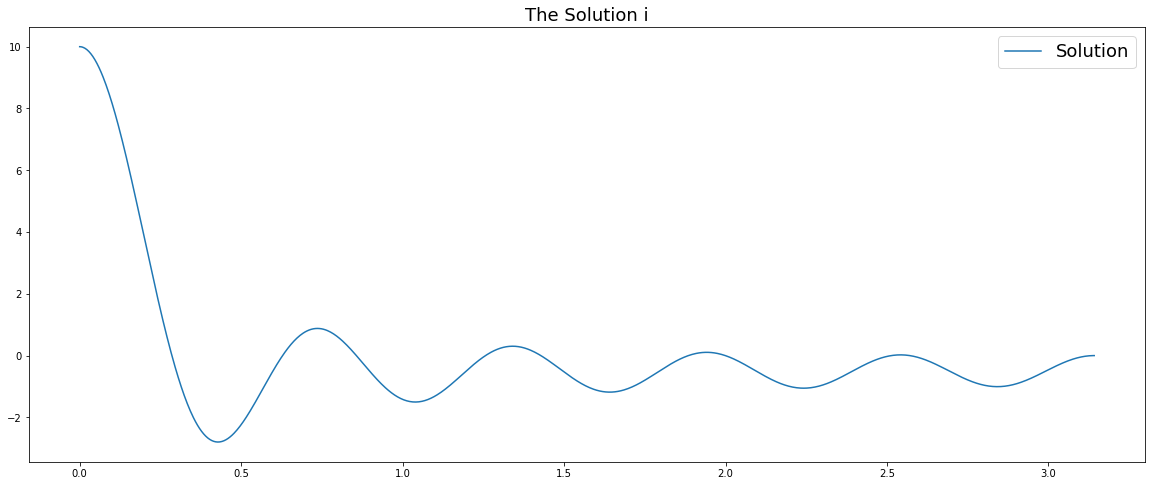

In [39]:
X = np.linspace(0, np.pi, 1000)
plt.figure(figsize=(20, 8))
plt.title('The Solution i', fontsize = 18)
plt.plot(X, u(X), label = 'Solution')
plt.legend(fontsize = 18)

Let us use the method of numerical differentiation to check our results.

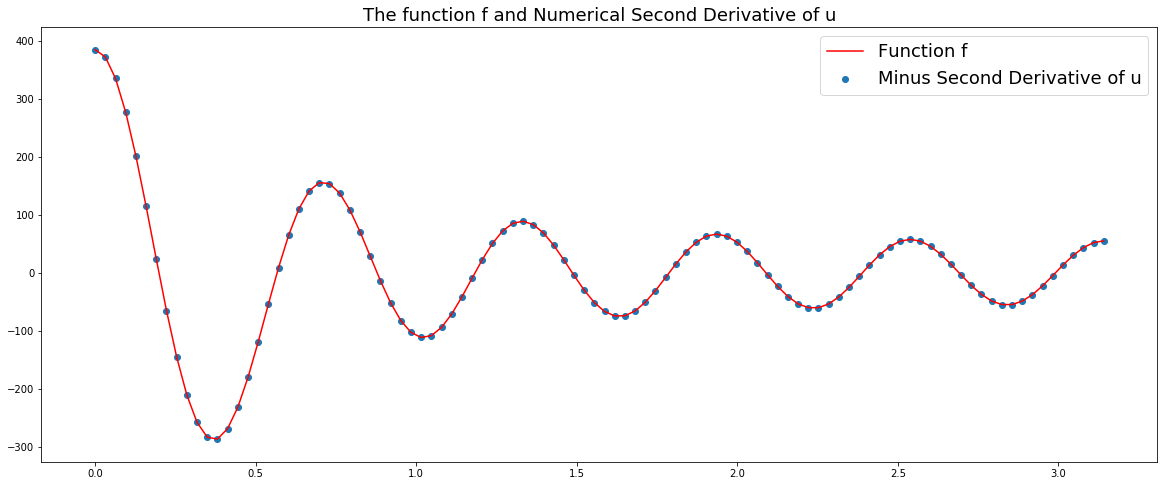

In [40]:
def gradgrad(u, X):
    h = 0.001
    return (u(X+h) - 2 * u(X) + u(X-h))/(h**2)


X = np.linspace(0, np.pi, 100)
plt.figure(figsize=(20, 8))
plt.title('The function f and Numerical Second Derivative of u', fontsize = 18)
plt.plot(X, f(X), label = 'Function f', color = 'red')
plt.scatter(X, - gradgrad(u, X), label = 'Minus Second Derivative of u')
plt.legend(fontsize = 18)

Similarly, let us investigate the following function, which again satisfies the given conditions above:

$$
    f(x) = x^4 - 2 \pi^2 x^2 + \frac{7 \pi^4}{15} 
$$

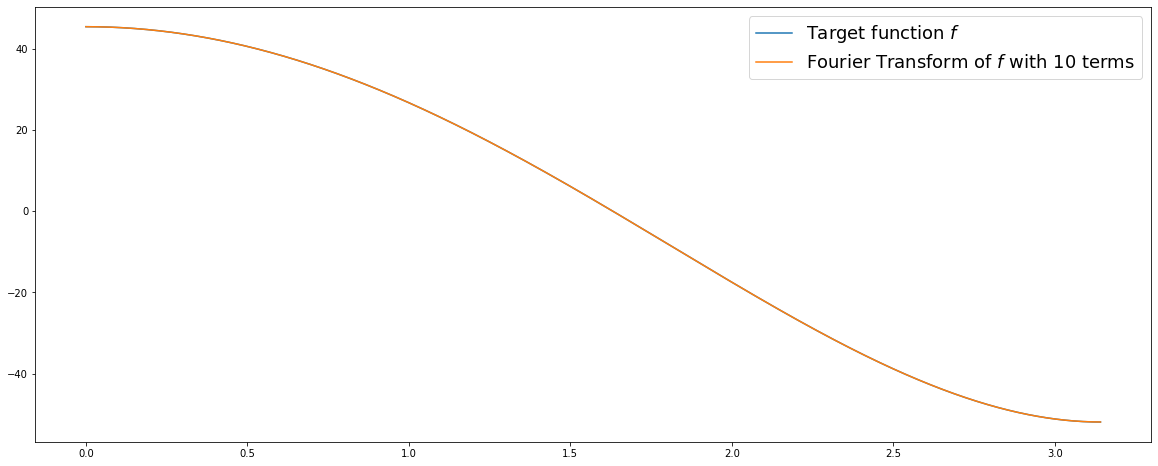

In [41]:
N = 10
X = np.linspace(0, np.pi, 1000)
F = Fourier(lambda X: X**4 - 2 * np.pi**2 * X**2 + (7*np.pi**4)/(15) ,-np.pi,np.pi,N)
a0, coefa, coefb = F.coefficients()
s = F.evaluate(X, a0, coefa, coefb)
F.plot(X,s)

We observe that 10 terms is a good enough approximation. Let's make sure the conditions are satisfied.

In [42]:
a0, coefb

(-1.7763568394002505e-15, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

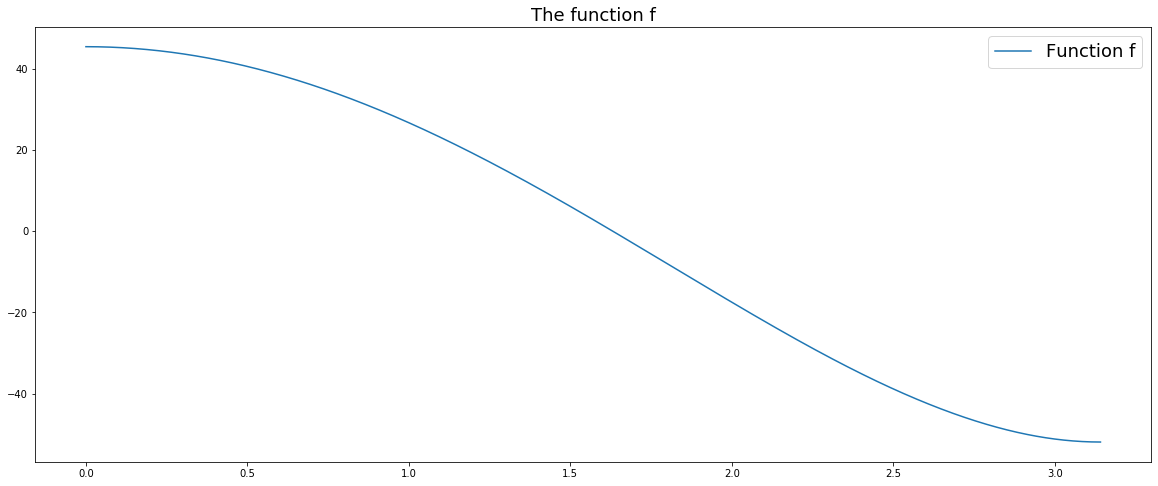

In [43]:
def u(x):
    s = np.zeros(len(x))
    for i in range(1,11):
        s += (coefa[i-1] /i**2) * np.cos(i*x)
    return s


X = np.linspace(0, np.pi, 1000)
plt.figure(figsize=(20, 8))
plt.title('The function f', fontsize = 18)
plt.plot(X, s, label = 'Function f')
plt.legend(fontsize = 18)

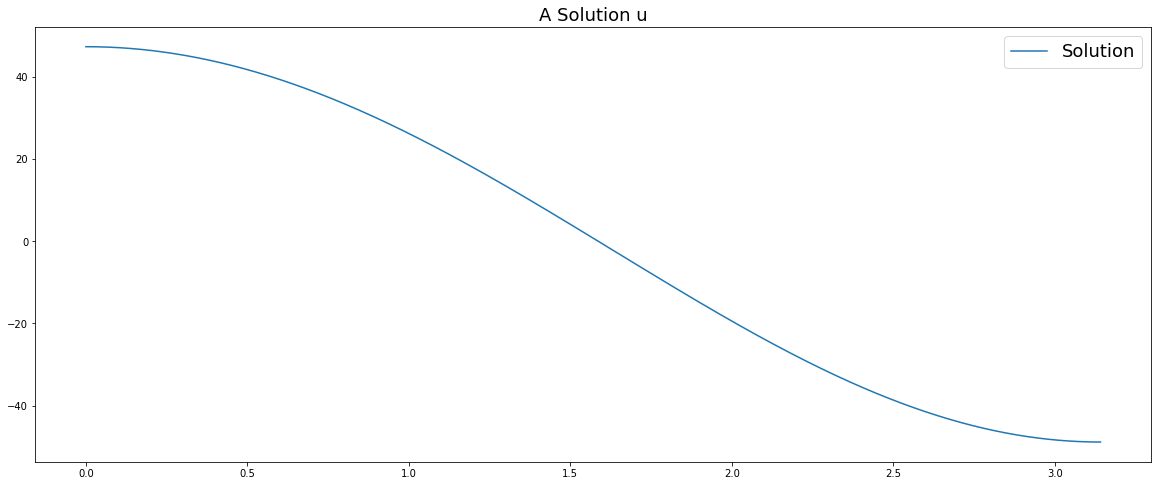

In [44]:
X = np.linspace(0, np.pi, 1000)
plt.figure(figsize=(20, 8))
plt.title('A Solution u', fontsize = 18)
plt.plot(X, u(X), label = 'Solution')
plt.legend(fontsize = 18)

Again, let us numerically check the results.

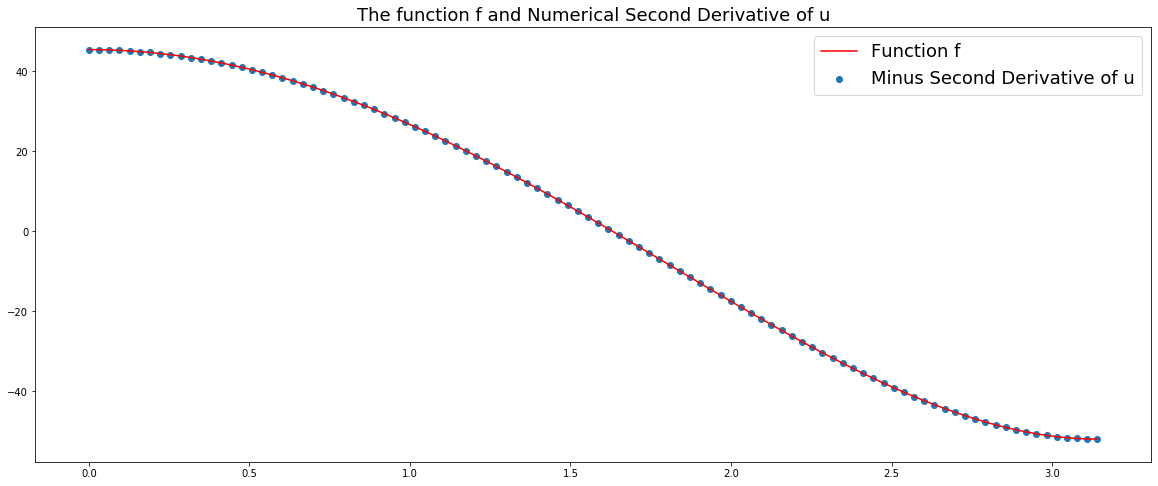

In [45]:
X = np.linspace(0, np.pi, 100)
plt.figure(figsize=(20, 8))
plt.title('The function f and Numerical Second Derivative of u', fontsize = 18)
plt.plot(X, F.evaluate(X, a0, coefa, coefb), label = 'Function f', color = 'red')
plt.scatter(X, - gradgrad(u, X), label = 'Minus Second Derivative of u')
plt.legend(fontsize = 18)

## A More Numerical Approach

In this section, we are going to introduce a more numerical method that we came up with to solve the Poisson equation numerically. Due to time constraints, we do not give an example for this solution but it can be constructed very easily. 

In the last part, we saw that the second derivative of a twice differentiable function $\phi$ can be approximated as follows:

$$
\phi''(x)  = \frac{\phi(x+h) - 2 \phi(x) + \phi(x-h)}{h^2}
$$

Let us again consider the Poisson differential equation but with different boundary conditions and interval:

$$
    \begin{cases}
      - u''(x) = f(x) \quad \quad x \in (0, 1) \\
      u(0) = u(1) = 0
    \end{cases} 
$$

Note that the different boundary conditions are introduced just for the sake of convenience and will not effect the main idea behind the numerical solution. The trick is the following: in order to find a numerical solution, let us discretize our function into $N+1$ equidistant points $0,\frac{1}{N},...,\frac{j}{N},...,1$ between 0 and 1 and use the approximation for the second derivative to calculate the function. In this case, let us denote $u_j := u(j/N)$ and select $h = \frac{1}{N}$ for approximation of the second derivative. Then, we obtain the following set of equations:

$$
    \begin{cases}
    u(j = 0) = u_0 = 0 \\
    u(j = N) = u_N = 0 \\
    u''(x = \frac{j}{N}) = \frac{\phi(\frac{j+1}{N}) - 2 \phi(\frac{j}{N}) + \phi(\frac{j-1}{N})}{h^2} = - f(x = \frac{j}{N}) \Longleftrightarrow u_{j+1} - 2 u_j + u_{j-1} = - h^2 f_j \quad \forall \quad 0 < j < N 
    \end{cases} 
$$

Making the following definitions, all of these equations can be written in the matrix form as follows:


$$
    M \cdot u = h^2 f  
$$

$$
    \begin{align}
    u &= \begin{bmatrix}
           u_{1} \\
           u_{2} \\
           \vdots \\
           u_{N-1}
         \end{bmatrix}
  \end{align} \in M_{N-1 \times 1}[\mathbf{R}]
$$
 
$$
   \begin{align}
    f &= \begin{bmatrix}
           f_{1} \\
           f_{2} \\
           \vdots \\
           f_{N-1}
         \end{bmatrix}
  \end{align} \in M_{N-1 \times 1}[\mathbf{R}]
$$

$$  M=\left(\begin{array}{ccccc} 2 & -1 & 0 & \ldots & 0 \\ -1 & 2 & -1 & \ldots & 0 \\ \vdots & & & &\vdots \\ 0  & 0 & \ldots & 2 & -1 \end{array}\right) \in M_{N-1 \times N-1}[\mathbf{R}]
$$

which is a linear system of equations that can be solved by Gaussian elimination. Note that one has to be careful while using this method since there can be problems arising due to discretizaiton.

We observe that inverse of $M$ can be written very nicely by the following code. We observe that there is a very clear pattern and an explicit equation can probably be found but this is beyond the scope of this notebook due to time constraints. 

In [46]:
import fractions
np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})
import numpy as np
N = 6
M = np.zeros((N,N))
for i in range(N):
    row = M[i]
    for j in range(N):
        if i == j:
            row[j] = 2
        if i == j+1:
            row[j] = -1
        if i == j-1:
            row[j] = -1
            
M, np.linalg.inv(M)

(array([[2, -1, 0, 0, 0, 0],
        [-1, 2, -1, 0, 0, 0],
        [0, -1, 2, -1, 0, 0],
        [0, 0, -1, 2, -1, 0],
        [0, 0, 0, -1, 2, -1],
        [0, 0, 0, 0, -1, 2]]), array([[6/7, 5/7, 4/7, 3/7, 2/7, 1/7],
        [5/7, 10/7, 8/7, 6/7, 4/7, 2/7],
        [4/7, 8/7, 12/7, 9/7, 6/7, 3/7],
        [3/7, 6/7, 9/7, 12/7, 8/7, 4/7],
        [2/7, 4/7, 6/7, 8/7, 10/7, 5/7],
        [1/7, 2/7, 3/7, 4/7, 5/7, 6/7]]))

## Conclusion

- We observe that the Fourier Series provides us with a way to deal with complex differential equations in a more simple way thanks to simplicity of sine and cosine function and their ability to approximate many functions with an infinite sum.

- Numerical methods also provide us with interesting ways to solve differential equations however one has to be careful while applying such methods due to their shortcomings or inaccuracies in some cases!